# Ada boost classifier

## Step 1 : Include all required libraries.

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

## Step 2 : Defining the Adaboost class. And algorithm as:
    input:
      training set S = (x1, y1), . . . ,(xm, ym)
      weak learner WL
      number of rounds T
    initialize D(1) = ( 1/m , . . . ,1/m ).
    for t = 1, . . . , T:
      invoke weak learner ht = WL(D(t), S)
      compute et=sum_i_m(Di(t)*1[yi!=ht(xi)])
      let wt =1/2*log(1-et/et)
      update D(t+1)i = D(t)i*exp(−wt*yi*ht(xi))/sum j=1 to m  D(t)j*exp(−wt*yj*ht(xj ))for all i = 1, . . . , m
    output the hypothesis hs(x) = sign(sum t=1 to T wt*ht(x)).

In [73]:
class AdaBoost_classifier:
    # Defining the initial values of the variables
    def __init__(self):
        self.decision_stumps = None
        self.decision_stump_weights = None
        self.classifier_errors = None
        self.classifier_sample_weights = None

    # checking the values of y label as +1 and -1 
    def check_Y_range(self, X, y):
        if set(y) == {-1, 1} : 
          return X, y
        else :
          return False

    # Fitting the model using decision stumps.
    def fit_model(self, X , y , iterations , iteration_information):
        X, y = self.check_Y_range(X, y)
        n = X.shape[0]

        # initialise numpy arrays
        self.classifier_sample_weights = np.zeros(shape=(iterations, n))
        self.decision_stumps = np.zeros(shape=iterations, dtype=object)
        self.decision_stump_weights = np.zeros(shape=iterations)
        self.classifier_errors = np.zeros(shape=iterations)

        # initialize weights uniformly as 1/n n= number of examples
        self.classifier_sample_weights[0] = np.ones(shape=n) / n

        for t in range(iterations):

            # fit  weak learner use decision tree classifier with depth 1 and leaves as 2 to create a decision stump
            curr_sample_weights = self.classifier_sample_weights[t]
            stump = DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
            stump = stump.fit(X, y, sample_weight=curr_sample_weights)

            # calculate error and stump weight from weak learner prediction error = 1/2*log(1/e-1)
            stump_pred = stump.predict(X)
            err = curr_sample_weights[(stump_pred != y)].sum()
            stump_weight = np.log((1 - err) / err) / 2

            # update sample weights by usng the formula D*e(-W*y*h(x))
            new_sample_weights = (
                curr_sample_weights * np.exp(-stump_weight * y * stump_pred)
            )            
            new_sample_weights /= new_sample_weights.sum()

            if iteration_information == True:
              print("Error for iteration ",t," is ",err,'\n')
              print("Stump Weight for iteration ",t," is ",stump_weight,'\n')
              print("New Stump Weight for iteration ",t," is ",new_sample_weights,'\n')
            # If not final iteration, update sample weights for t+1
            if t+1 < iterations:
                self.classifier_sample_weights[t+1] = new_sample_weights

            # save results of iteration
            self.decision_stumps[t] = stump
            self.decision_stump_weights[t] = stump_weight
            self.classifier_errors[t] = err
        return self

    def predict(self, X):
        stump_predictions = np.array([s.predict(X) for s in self.decision_stumps])
        return np.sign(np.dot(self.decision_stump_weights, stump_predictions))

## Step 3 : Defining the functions used for visualizing the classifier.

In [74]:
# Defining the function to plot the decision boundary of adaboost classifier
def plot_adaboost_in2D(X,y,classifier=None,classifier_sample_weights=None):
    # checking for target to be 1 and -1 
    assert set(y) == {-1, 1}
    # Defining the figure size and the dpi
    figure, axes = plt.subplots(figsize=(7, 7), dpi=100)
    # background color set as white 
    figure.set_facecolor('white')
    # defining the boundary padding of the data points
    padding_for_boundary = 1
    x_min, x_max = X[:, 0].min() - padding_for_boundary, X[:, 0].max() + padding_for_boundary
    y_min, y_max = X[:, 1].min() - padding_for_boundary, X[:, 1].max() + padding_for_boundary
    
    # If sample weights are not given then assigning size using shape
    if classifier_sample_weights is not None:
        size = np.array(classifier_sample_weights) * X.shape[0] * 100
    else:
        size = np.ones(shape=X.shape[0]) * 100
    
    # Potting the positive that is 1 data points using scatter plot using color blue
    X_positive = X[y == 1]
    size_positive = size[y == 1]
    axes.scatter(*X_positive.T, s=size_positive, marker='+', color='blue')
    
    # Potting the negative that is -1 data points using scatter plot using color red
    X_negative = X[y == -1]
    size_negative = size[y == -1]
    axes.scatter(*X_negative.T, s=size_negative, marker='.', c='red')

    # if classifier is not provided then no decision boundary is drawn
    if classifier:
        plot_step = 0.01
        # using meshgrid to draw the decision boundary of adaboost classifier
        xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))
        Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        # If all predictions are positive class, adjust color map acordingly
        if list(np.unique(Z)) == [1]:
            fill_colors = ['b']
        else:
            fill_colors = ['r', 'b']
        axes.contourf(xx, yy, Z, colors=fill_colors, alpha=0.2)
    
    axes.set_xlim(x_min+0.5, x_max-0.5)
    axes.set_ylim(y_min+0.5, y_max-0.5)
    axes.set_xlabel('$x_1$')
    axes.set_ylabel('$x_2$')

## Step 4 : Defining the Function to create a random 2d dataset, and creating Training and test set. 

In [75]:
def make_2D_gaussian_dataset( n , random_seed):
    n_per_class = int(n/3)
    if random_seed:
        np.random.seed(random_seed)
    # using make_gaussian_quantiles to create a 2D data set.
    X, y = make_gaussian_quantiles(n_samples=n, n_features=2, n_classes=2)
    return X, y*2-1

## Step 5 : Creating the 2d Data set with n data points.

Total Data points : 99
Total Data points in traing set : 69
Total Data points in test set : 30


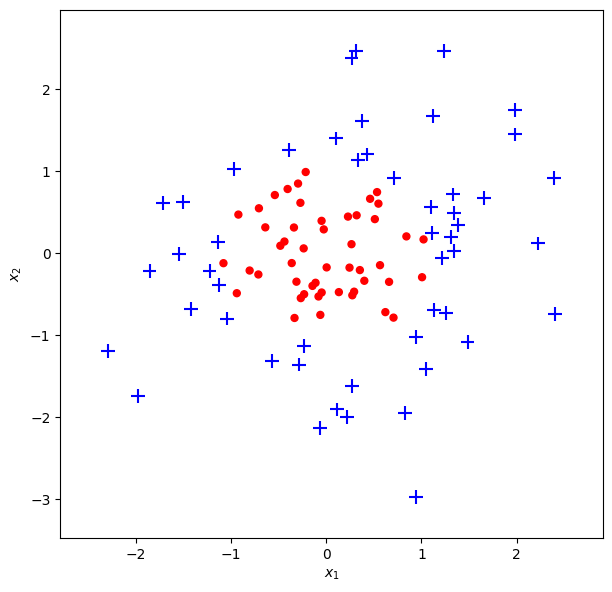

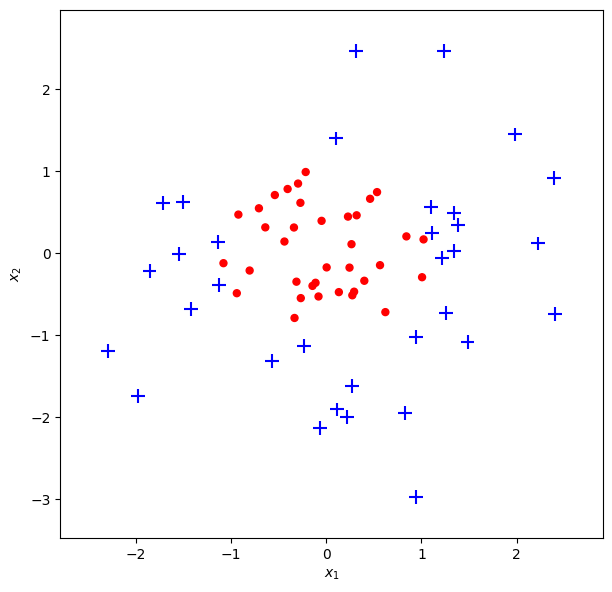

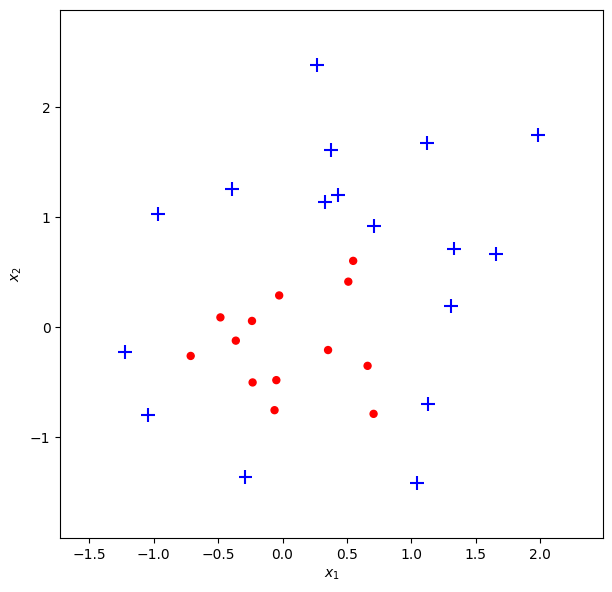

In [76]:
# defining n the number of total data points.
n = 99
X, y = make_2D_gaussian_dataset(n, random_seed=10)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
print("Total Data points :",n)
plot_adaboost_in2D(X, y)
print("Total Data points in traing set :",X_train.shape[0])
plot_adaboost_in2D(X_train, y_train)
print("Total Data points in test set :",X_test.shape[0])
plot_adaboost_in2D(X_test, y_test)

## Step 6 : Creating classifier and fitting the classifier with i terations/Weak Classifiers.  

In [77]:
# defining the number of iteations as i
i = 10
clf = AdaBoost_classifier().fit_model(X_train, y_train, iterations=i,iteration_information=True)
print("Final updated values of weights for ",i," Decision stumps are:")
print(clf.decision_stump_weights)

Error for iteration  0  is  0.2898550724637681 

Stump Weight for iteration  0  is  0.44804401227831786 

New Stump Weight for iteration  0  is  [0.01020408 0.025      0.01020408 0.025      0.01020408 0.01020408
 0.01020408 0.025      0.025      0.025      0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.025      0.025      0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.025      0.01020408
 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.025      0.025      0.025
 0.025      0.01020408 0.01020408 0.025      0.025      0.025
 0.01020408 0.01020408 0.01020408 0.025      0.01020408 0.01020408
 0.025      0.01020408 0.01020408 0.01020408 0.01020408 0.01020408
 0.01020408 0.01020408 0.01020408 0.025      0.01020408 0.025
 0.01020408 0.025      0.01020408] 

Error for iteration  1  is  0.34744897959183685 

Stump Weight for iteration  1  is  0.315135747

## Step 7 : plotting the classifier output and checking for error.

Train error: 2.898550724637681
Test error: 26.666666666666668


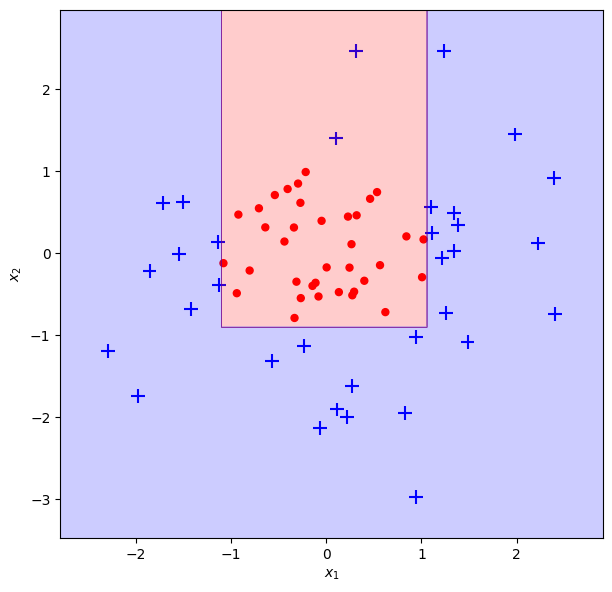

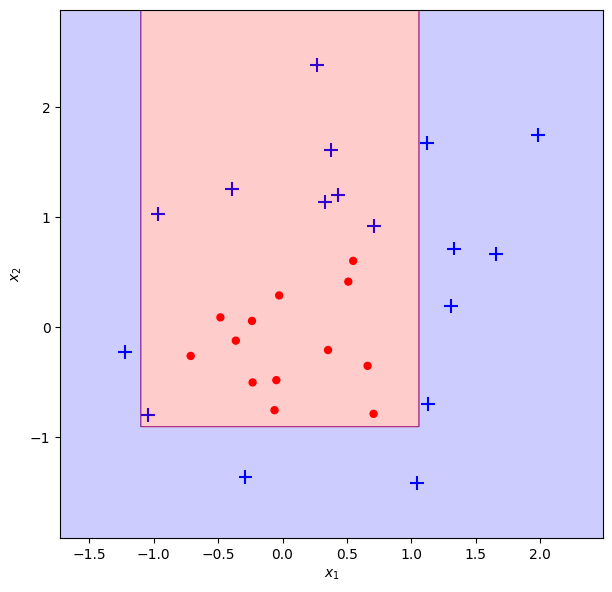

In [78]:
plot_adaboost_in2D(X_train, y_train, clf)
train_err = (clf.predict(X_train) != y_train).mean() * 100
print('Train error:',train_err)
plot_adaboost_in2D(X_test, y_test, clf)
test_err = (clf.predict(X_test) != y_test).mean() * 100
print('Test error:',test_err)

# Step 8 : Using the Adaboost provided in sklearn to check for accuracy of defined model.

Train error: 2.898550724637681
Test error: 26.666666666666668


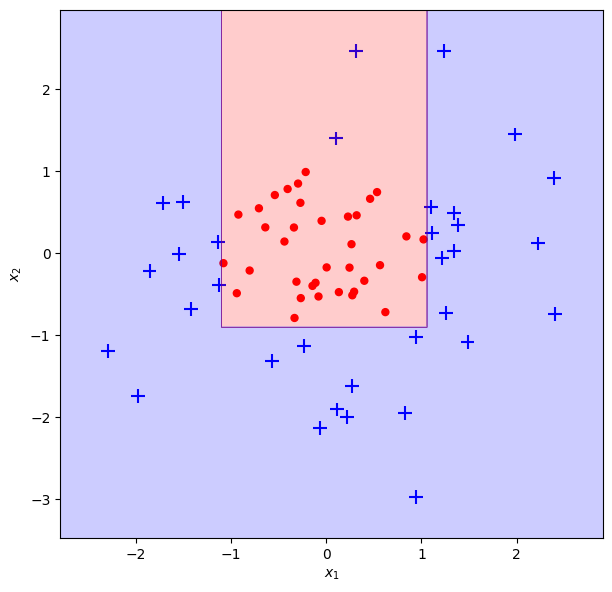

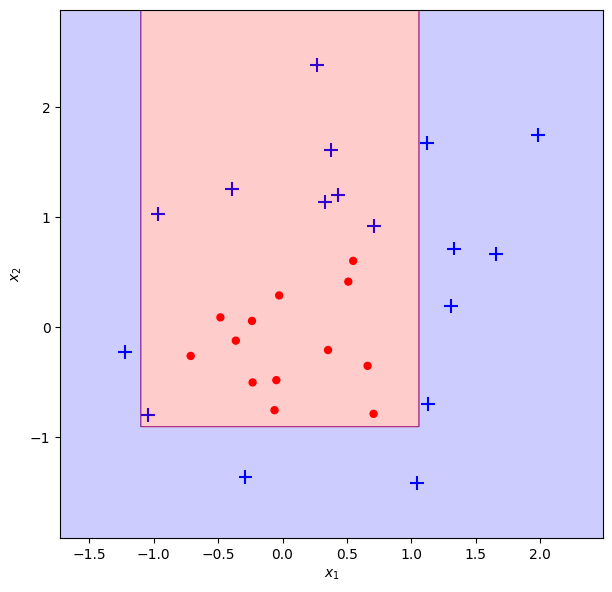

In [79]:
from sklearn.ensemble import AdaBoostClassifier
benchmark = AdaBoostClassifier(n_estimators=i, algorithm='SAMME').fit(X_train, y_train)
plot_adaboost_in2D(X_train, y_train, benchmark)
train_err = (benchmark.predict(X_train) != y_train).mean()*100
print('Train error:',train_err)
plot_adaboost_in2D(X_test, y_test, benchmark)
test_err = (benchmark.predict(X_test) != y_test).mean() * 100
print('Test error:',test_err)

## Step 9 : Comparing different values of iterations that is weak classifiers used for adaboost.

In [80]:
# defining the minimum numbers of iterations or weak classifier used for getting the minimum train error and test error
min_train = 0
min_test = 0

Test error for iteration  1  is : 36.666666666666664
Test error for iteration  2  is : 36.666666666666664
Test error for iteration  3  is : 30.0
Test error for iteration  4  is : 33.33333333333333
Test error for iteration  5  is : 26.666666666666668
Test error for iteration  6  is : 26.666666666666668
Test error for iteration  7  is : 26.666666666666668
Test error for iteration  8  is : 30.0
Test error for iteration  9  is : 26.666666666666668
Test error for iteration  10  is : 26.666666666666668
Test error for iteration  11  is : 26.666666666666668
Test error for iteration  12  is : 26.666666666666668
Test error for iteration  13  is : 26.666666666666668
Test error for iteration  14  is : 26.666666666666668
Test error for iteration  15  is : 26.666666666666668
Test error for iteration  16  is : 26.666666666666668
Test error for iteration  17  is : 26.666666666666668
Test error for iteration  18  is : 26.666666666666668
Test error for iteration  19  is : 26.666666666666668
Test error f

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  21  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  22  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  23  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  24  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  25  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  26  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  27  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  28  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  29  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  30  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  31  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  32  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  33  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  34  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  35  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  36  is : 26.666666666666668


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  37  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  38  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  39  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  40  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  41  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  42  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  43  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  44  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  45  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  46  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  47  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  48  is : 13.333333333333334


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Test error for iteration  49  is : 13.333333333333334
For test set
Minimum error is  13.333333333333334
Number of ierations to reach minimum error is  23


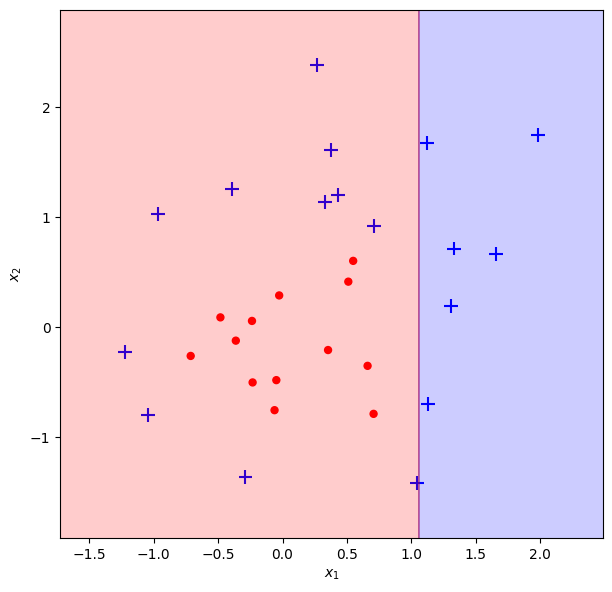

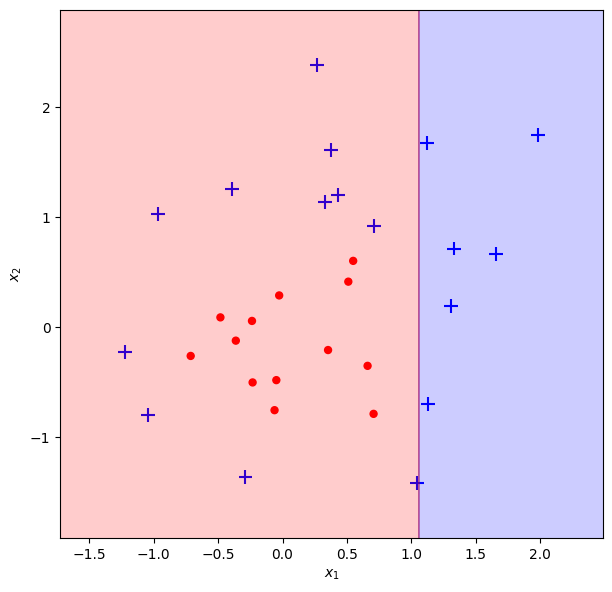

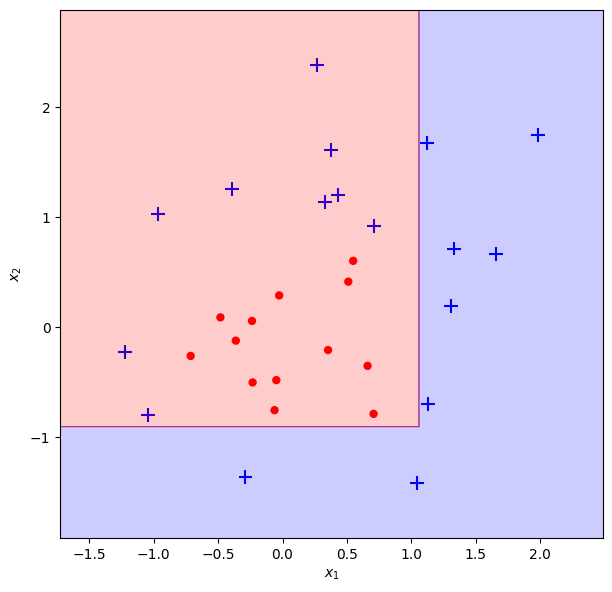

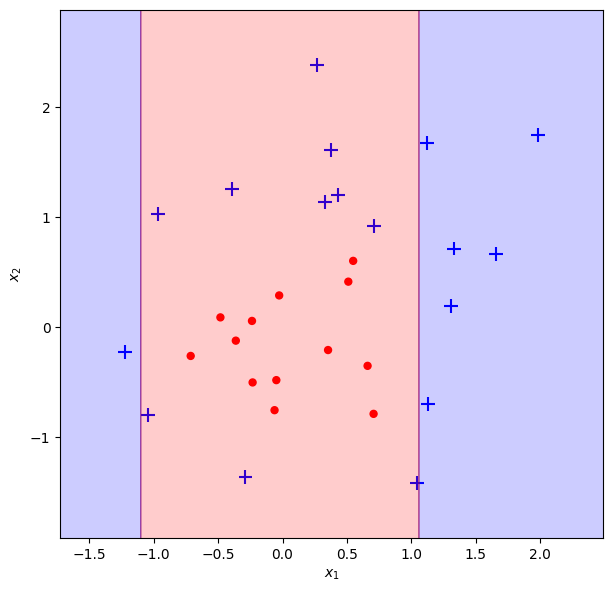

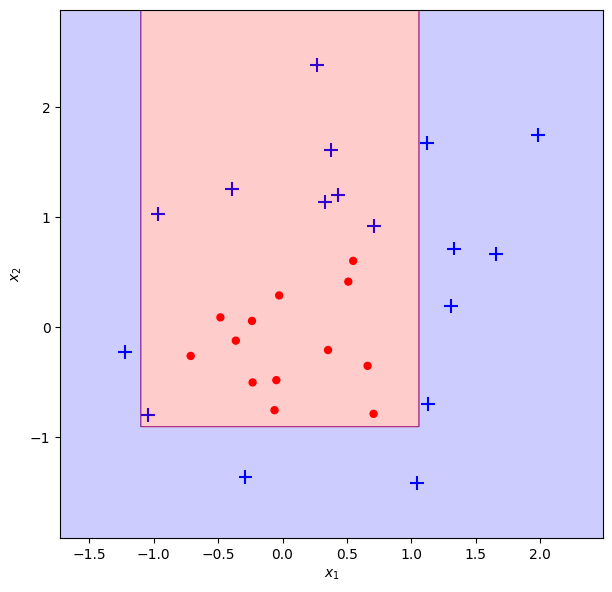

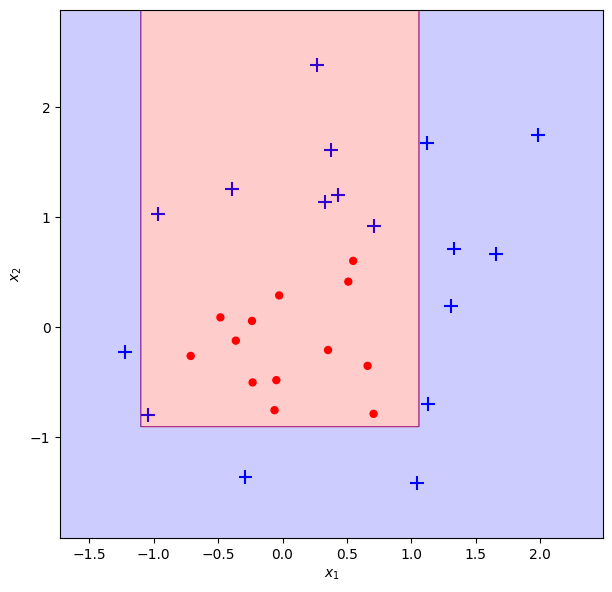

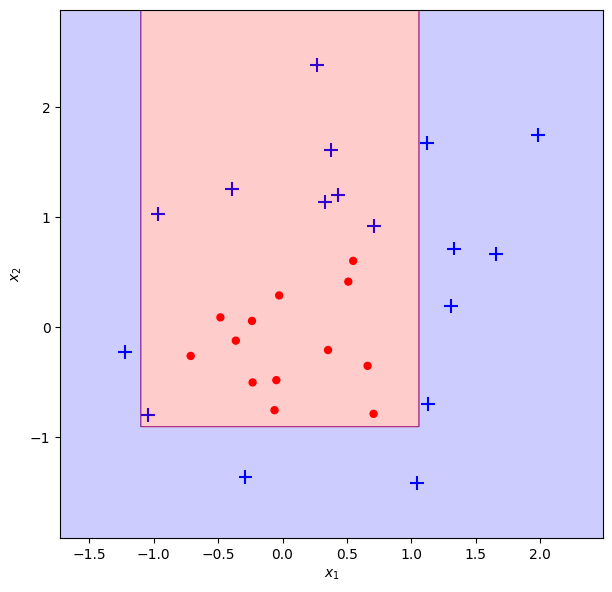

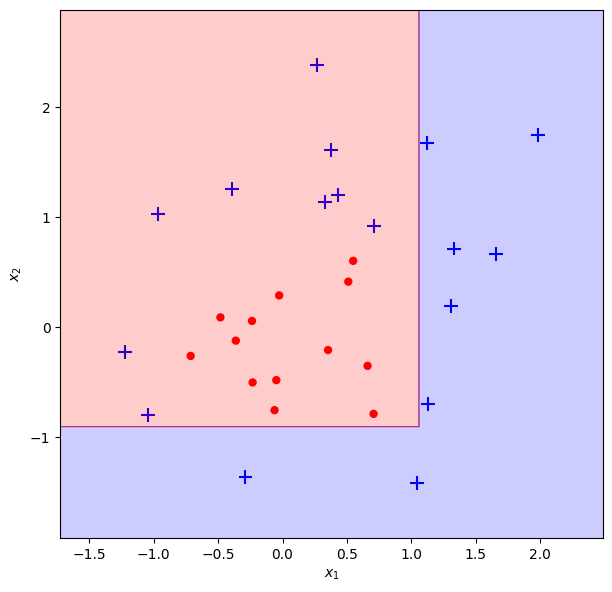

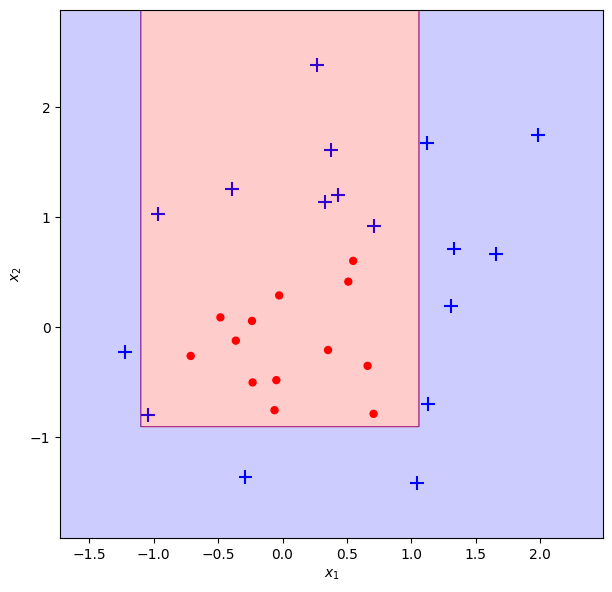

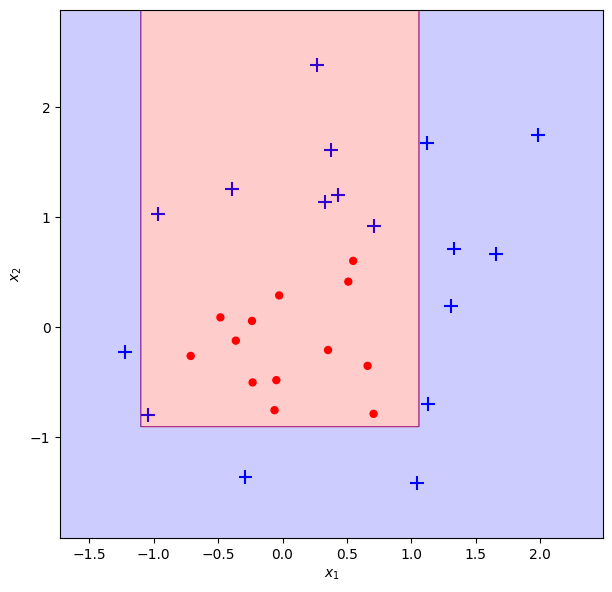

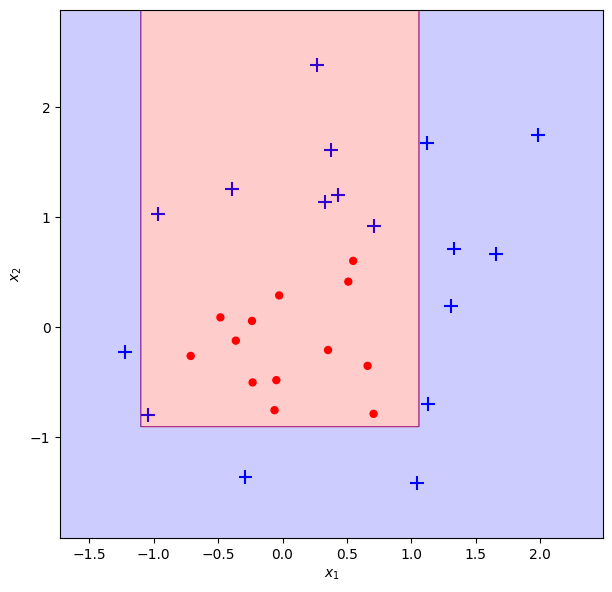

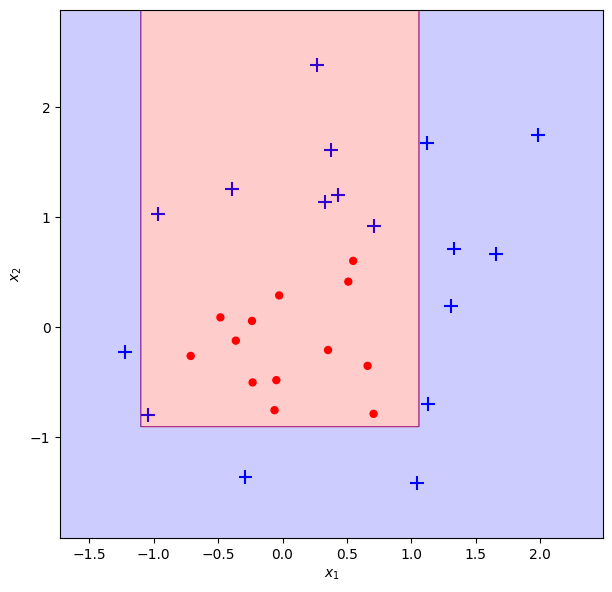

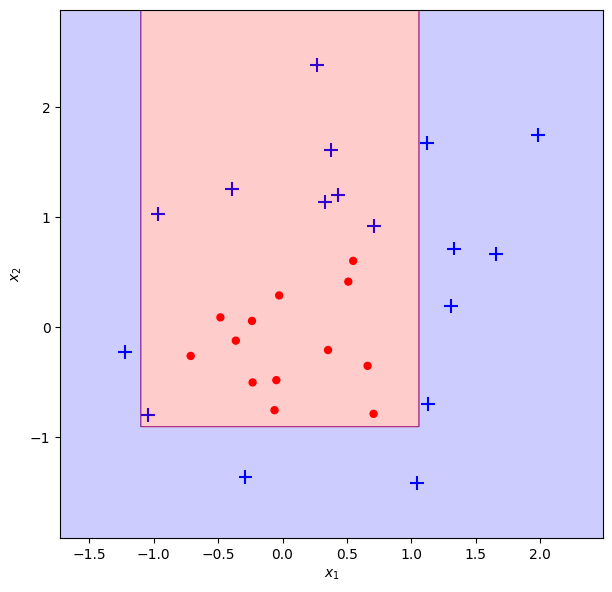

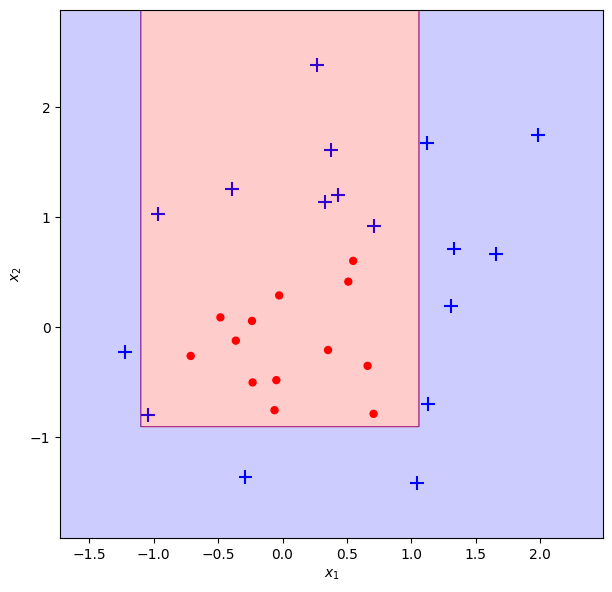

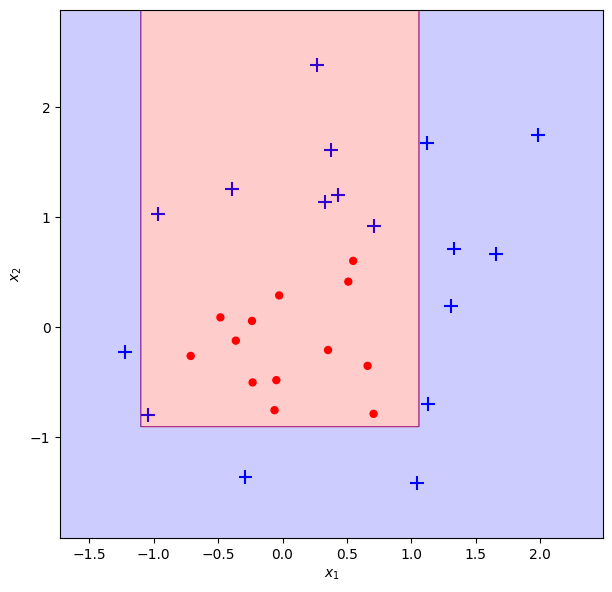

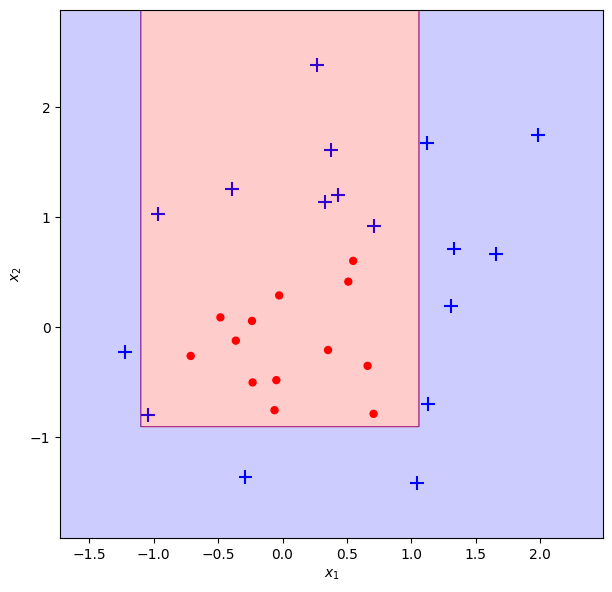

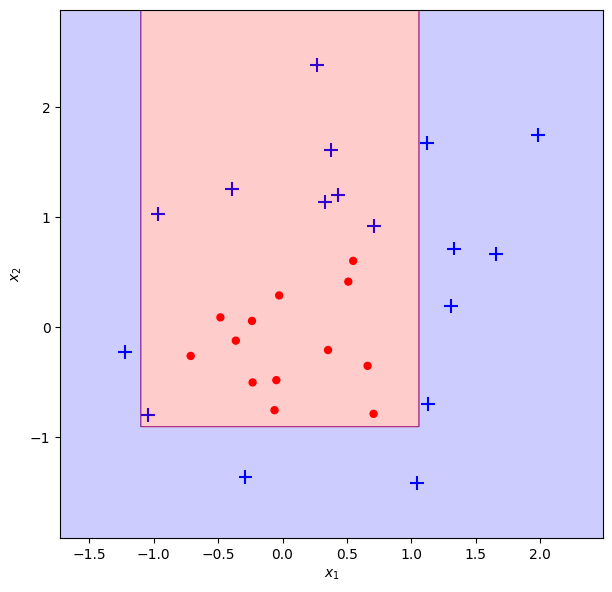

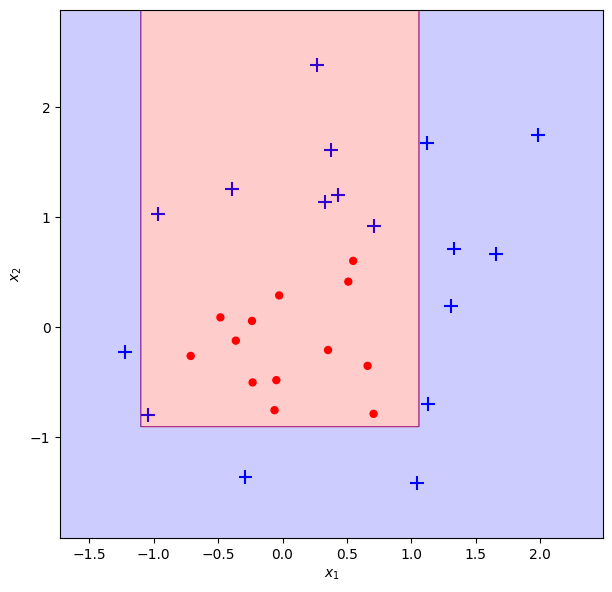

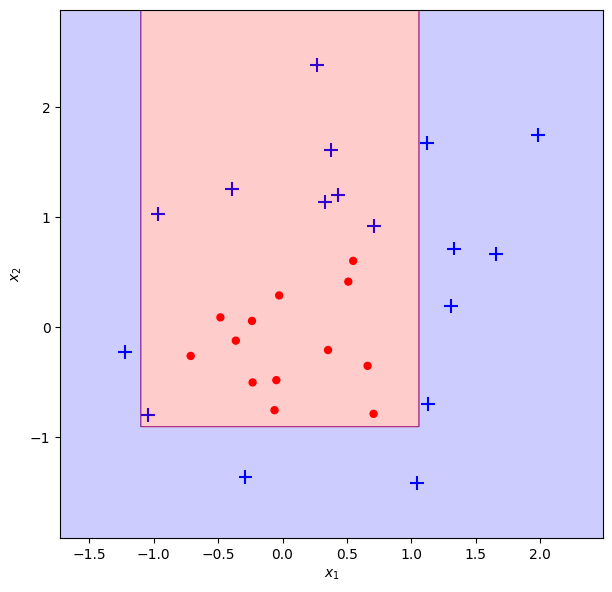

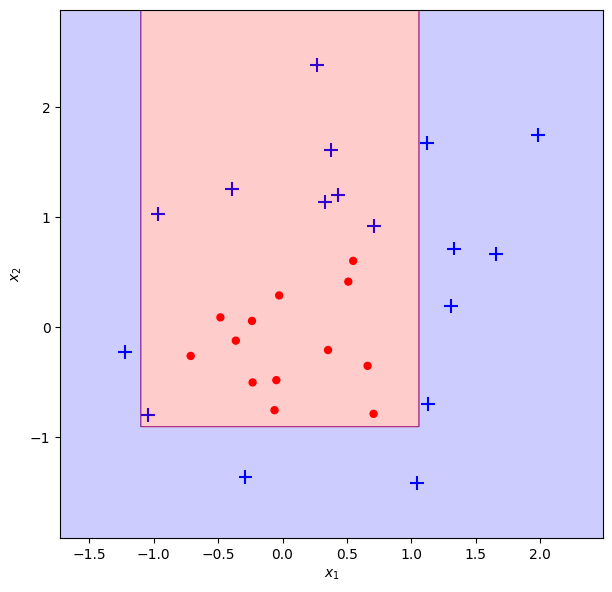

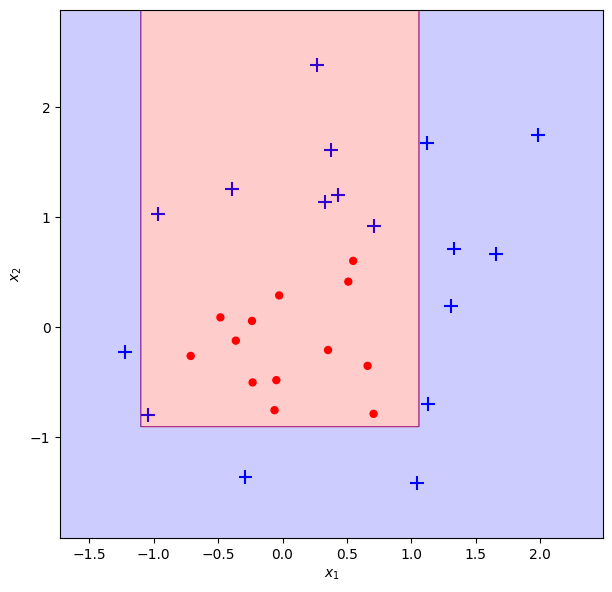

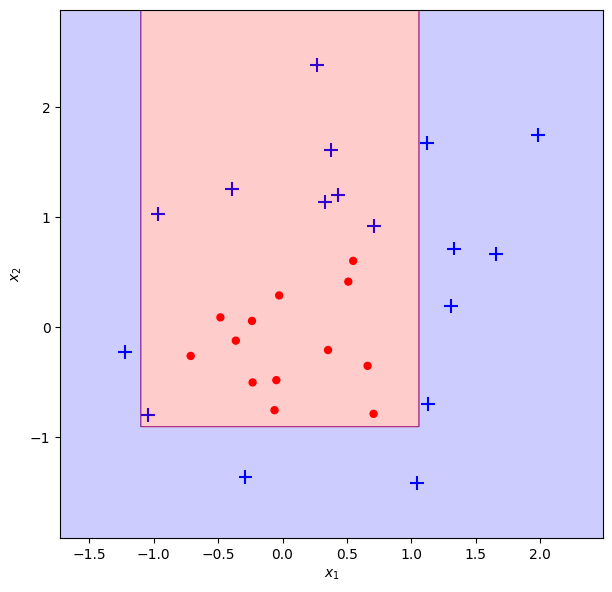

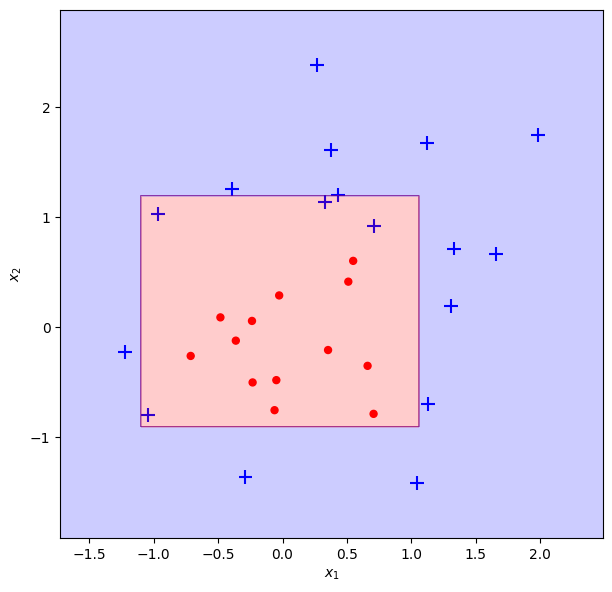

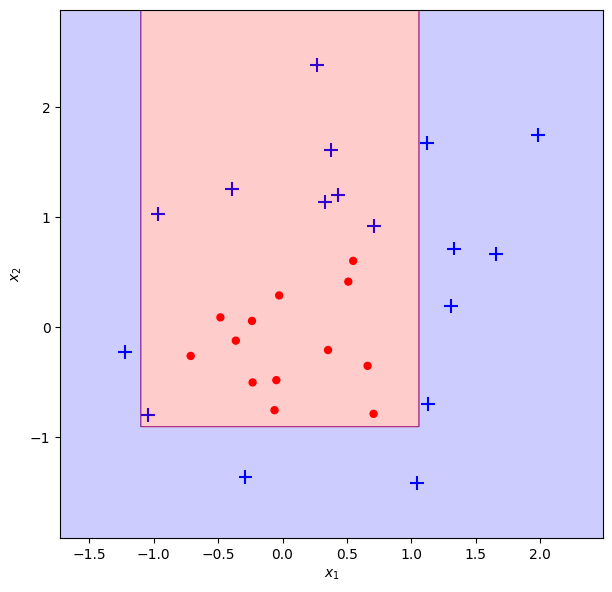

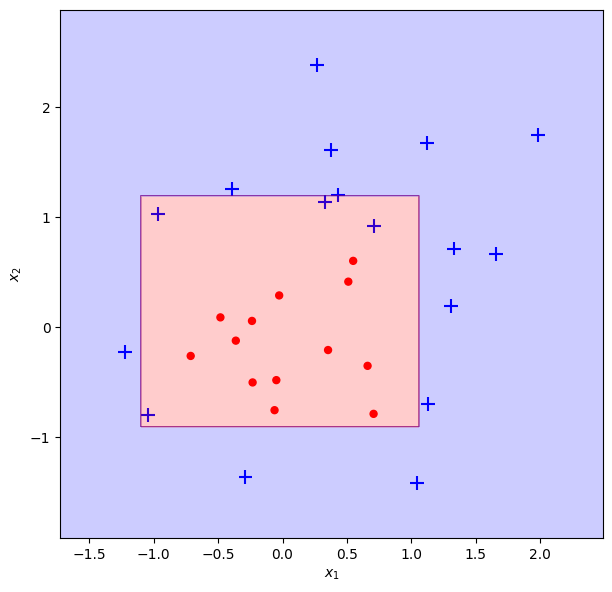

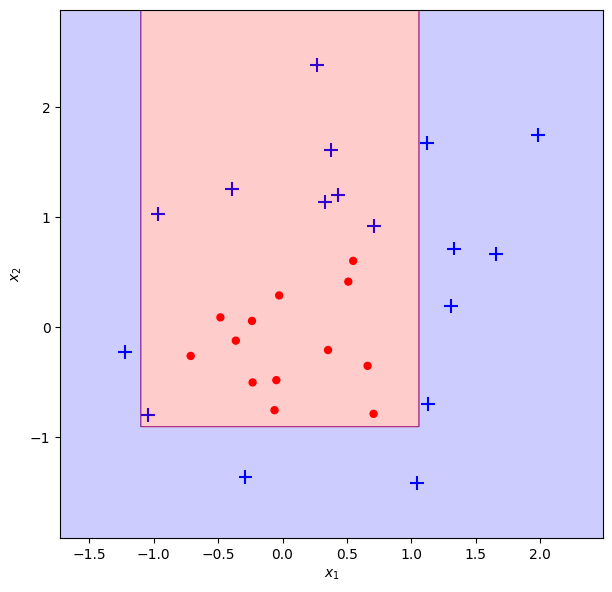

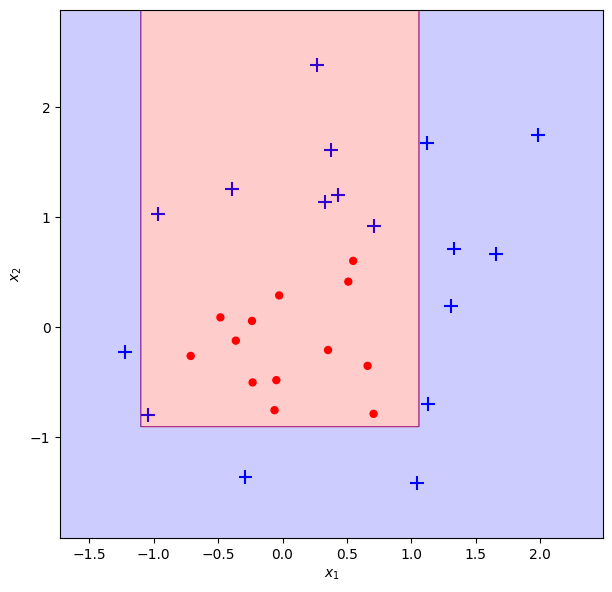

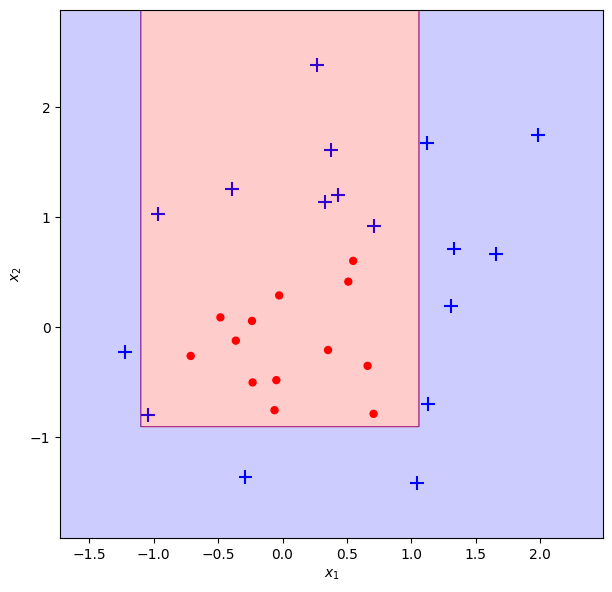

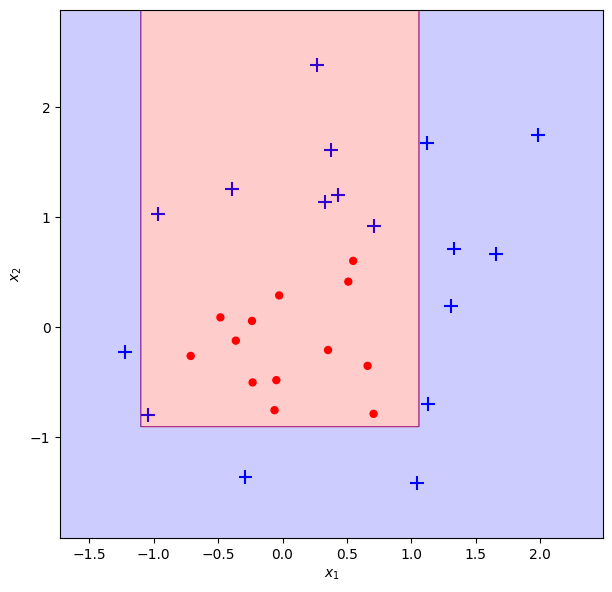

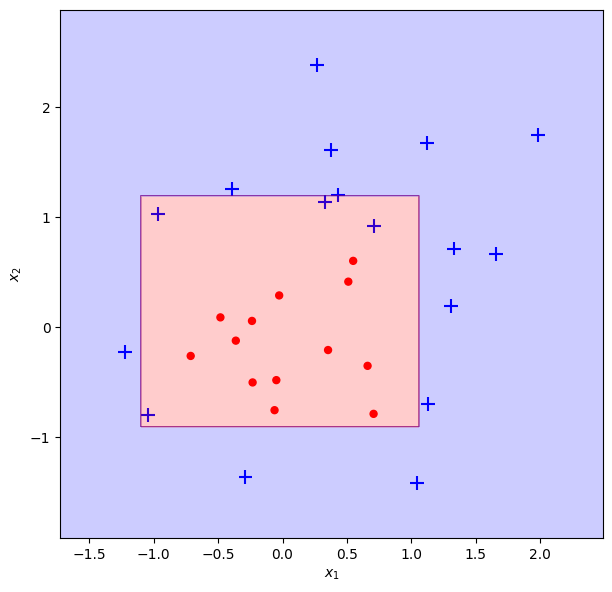

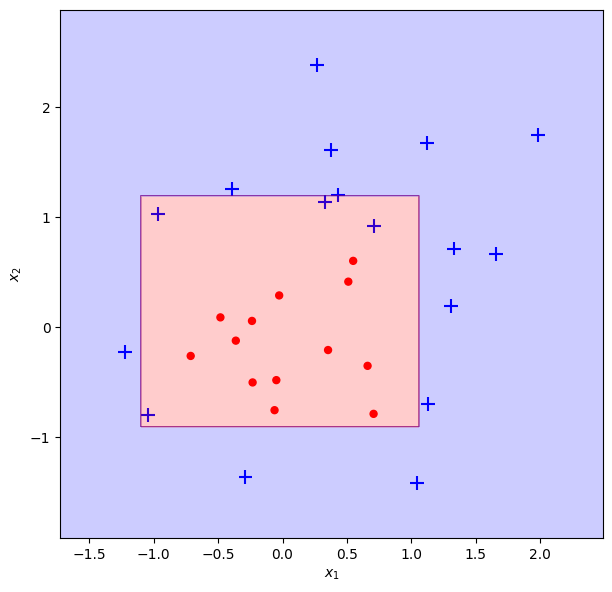

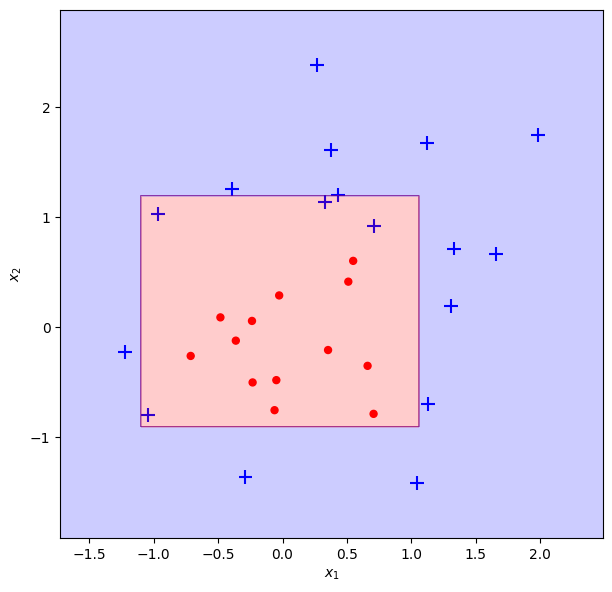

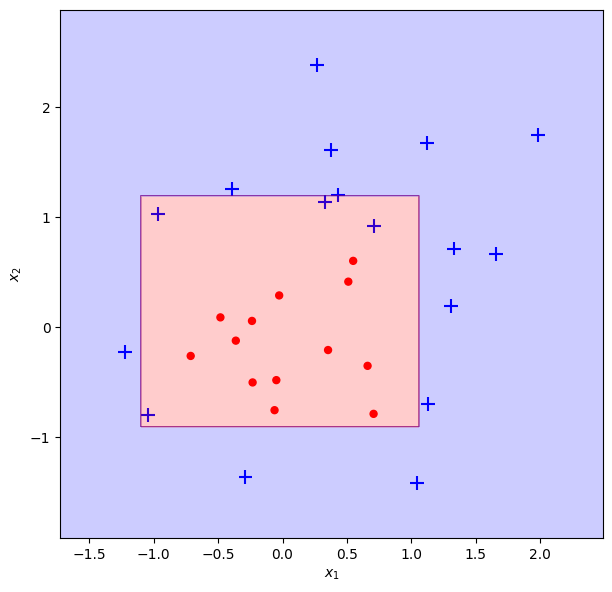

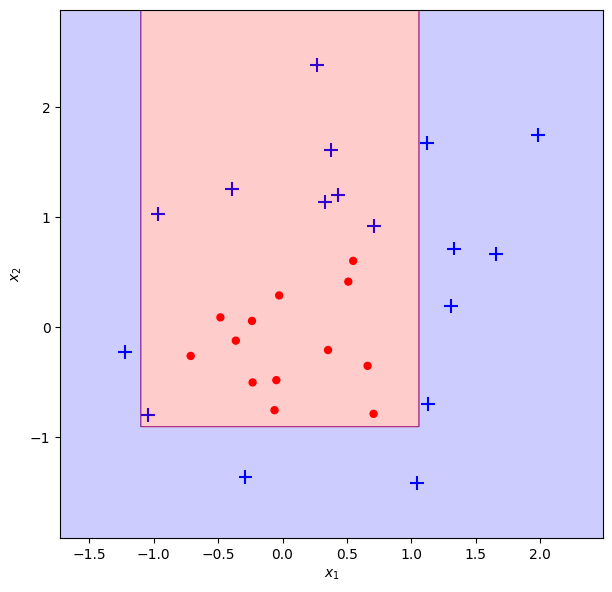

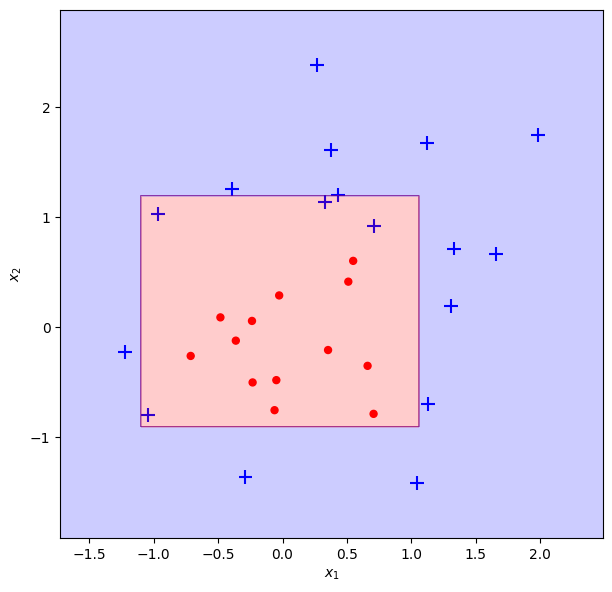

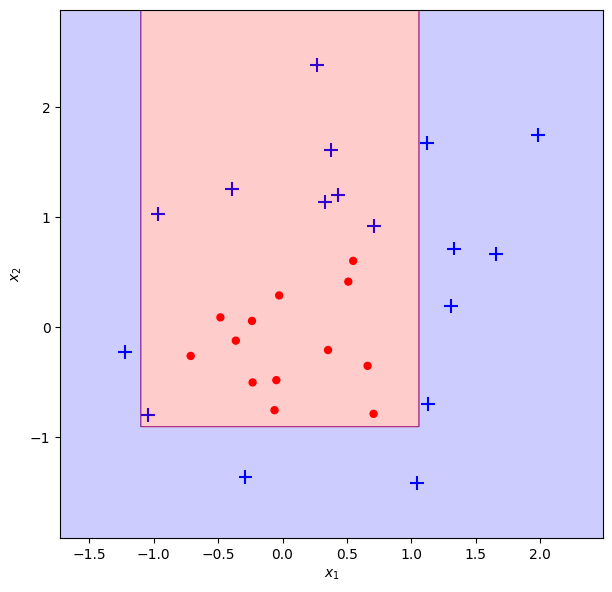

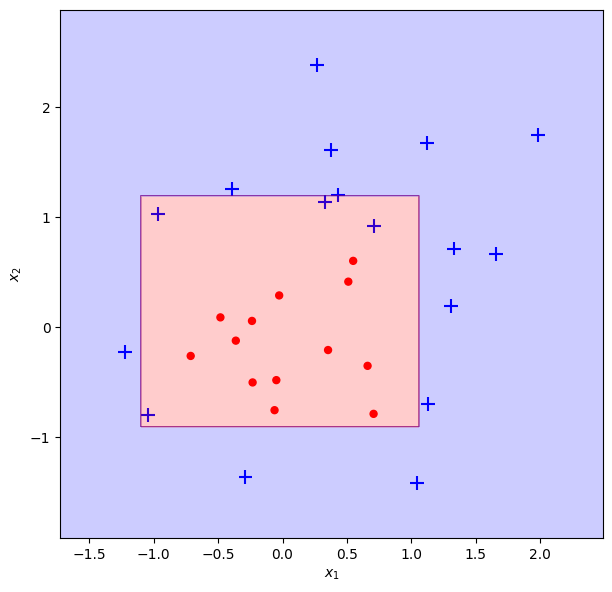

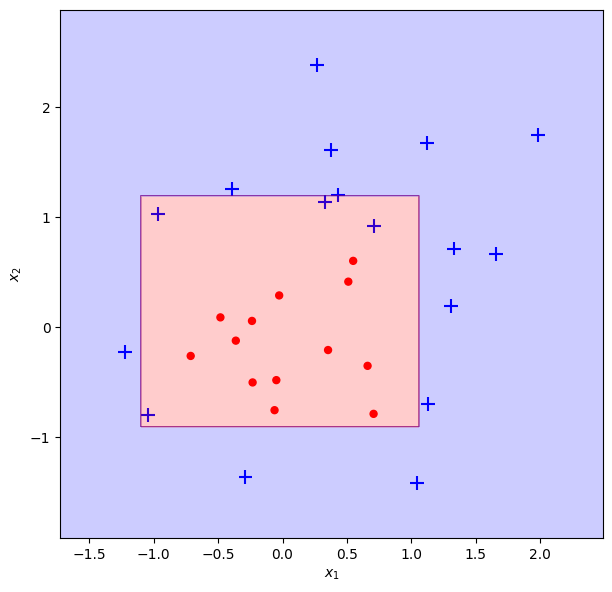

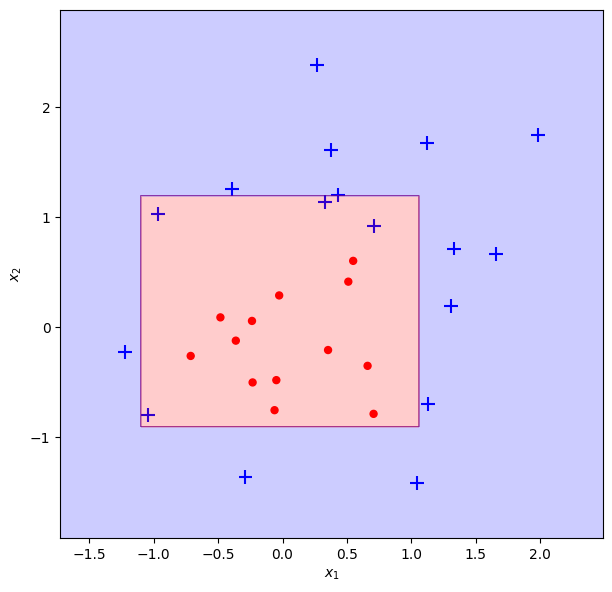

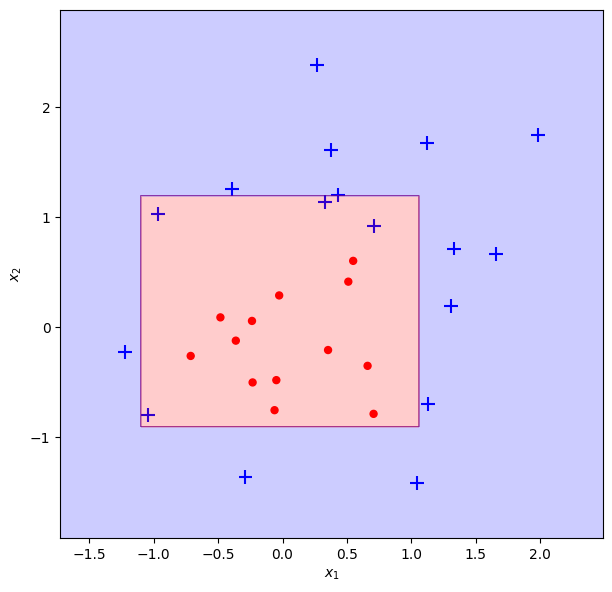

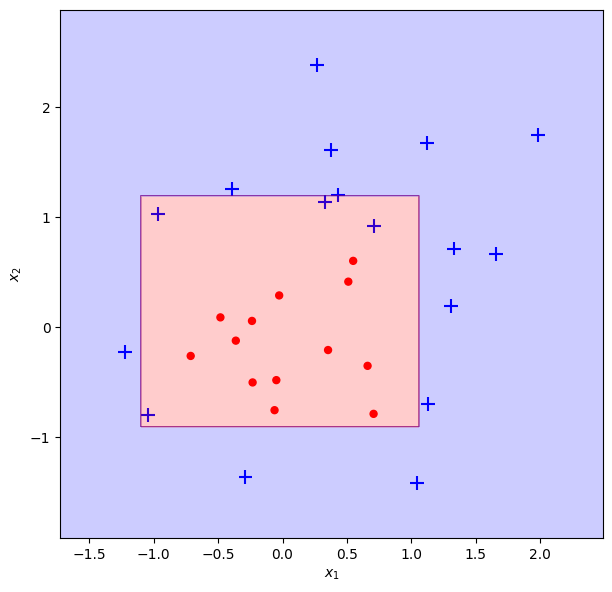

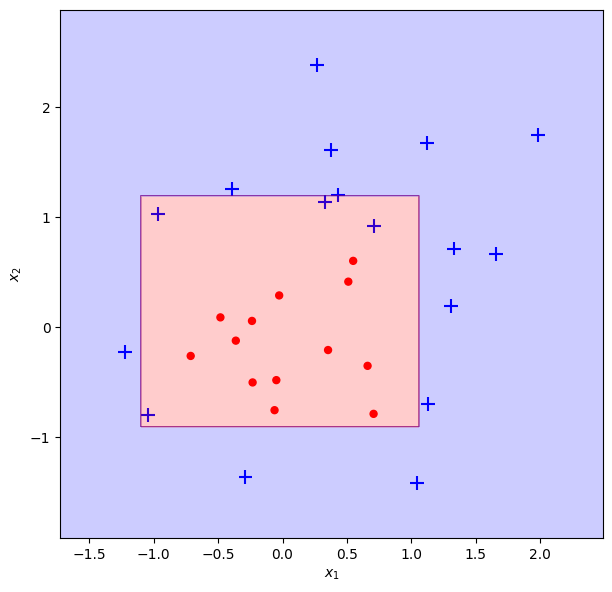

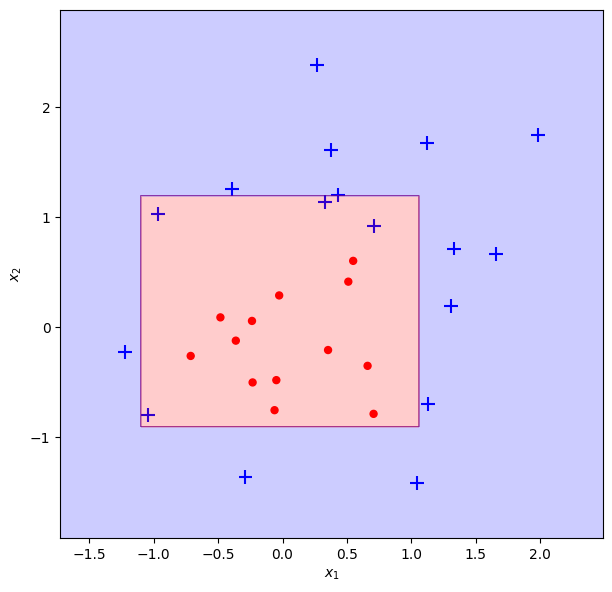

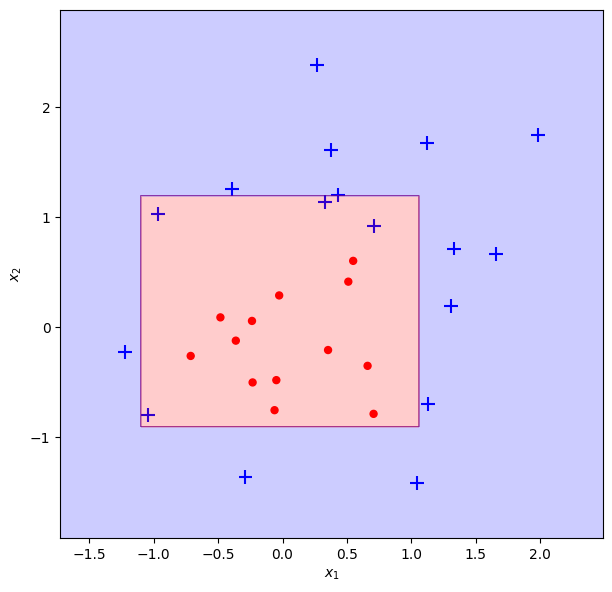

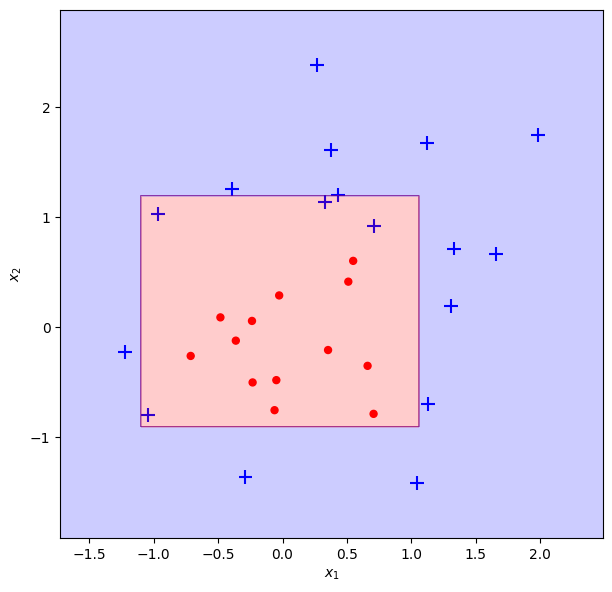

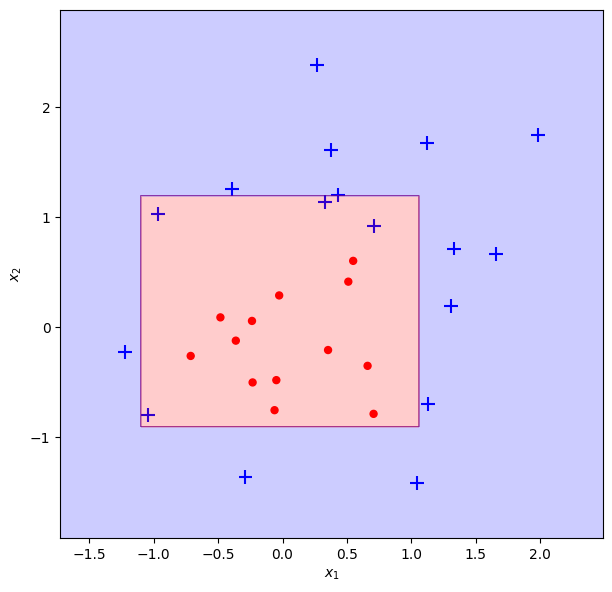

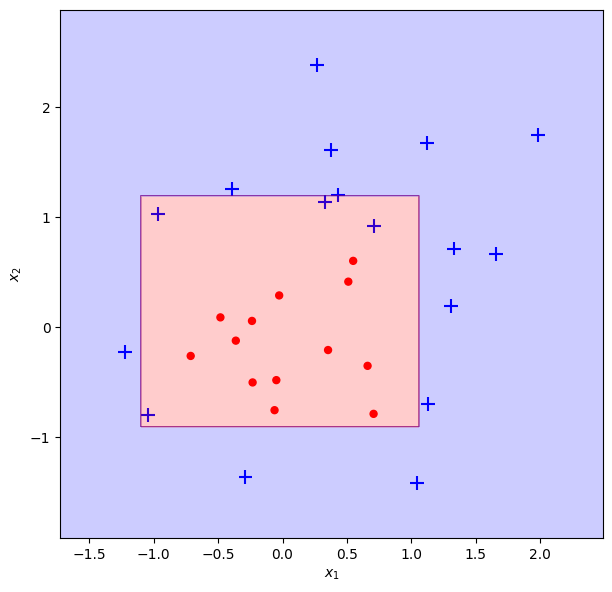

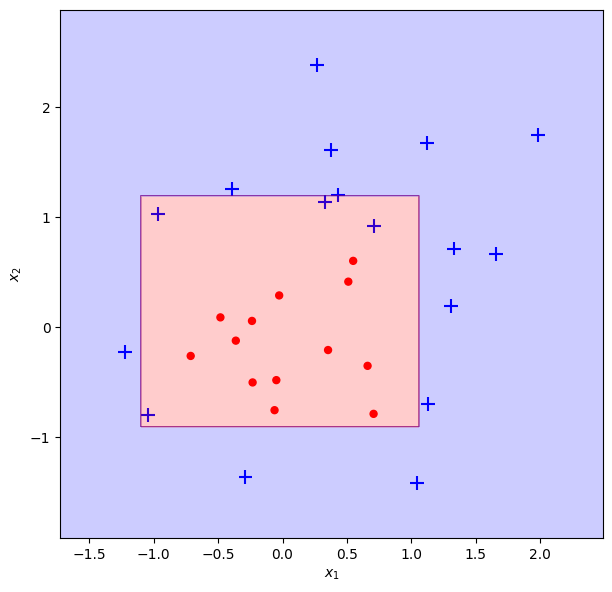

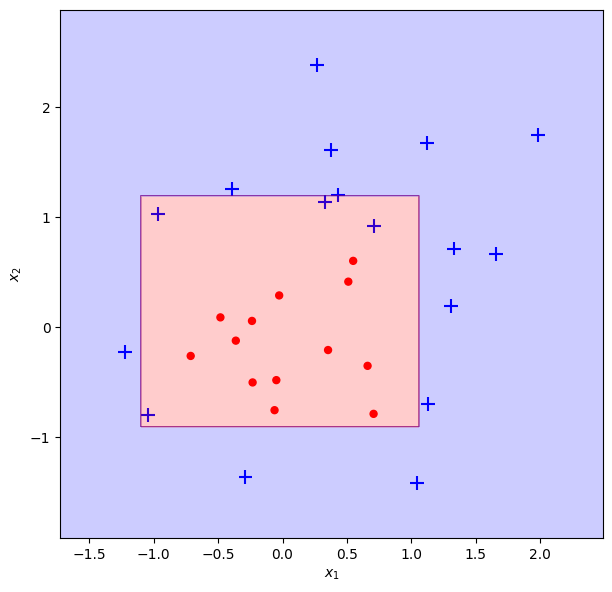

In [81]:
s1 = []
i=1
previous_test_err = 100.0
while i<n/2:
  clf = AdaBoost_classifier().fit_model(X_train, y_train, iterations=i,iteration_information=False)
  #plot_adaboost_in2D(X_train, y_train, clf)
  #train_err = (clf.predict(X_train) != y_train).mean() * 100
  #print('Train error:',train_err)
  if n < 100 :
    plot_adaboost_in2D(X_test, y_test, clf)
  test_err = (clf.predict(X_test) != y_test).mean() * 100
  print('Test error for iteration ',i,' is :',test_err)
  s1.append(test_err)
  i = i + 1
print("For test set")
print("Minimum error is ",min(s1))
print("Number of ierations to reach minimum error is ",s1.index(min(s1))+1) 
min_train = s1.index(min(s1))+1

Train error for iteration  1  is : 28.985507246376812
Train error for iteration  2  is : 28.985507246376812
Train error for iteration  3  is : 13.043478260869565
Train error for iteration  4  is : 15.942028985507244
Train error for iteration  5  is : 2.898550724637681
Train error for iteration  6  is : 2.898550724637681
Train error for iteration  7  is : 2.898550724637681
Train error for iteration  8  is : 13.043478260869565
Train error for iteration  9  is : 2.898550724637681
Train error for iteration  10  is : 2.898550724637681
Train error for iteration  11  is : 2.898550724637681
Train error for iteration  12  is : 2.898550724637681
Train error for iteration  13  is : 2.898550724637681
Train error for iteration  14  is : 2.898550724637681
Train error for iteration  15  is : 2.898550724637681
Train error for iteration  16  is : 2.898550724637681
Train error for iteration  17  is : 2.898550724637681
Train error for iteration  18  is : 2.898550724637681
Train error for iteration  19  i

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  21  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  22  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  23  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  24  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  25  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  26  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  27  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  28  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  29  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  30  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  31  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  32  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  33  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  34  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  35  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  36  is : 2.898550724637681


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  37  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  38  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  39  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  40  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  41  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  42  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  43  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  44  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  45  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  46  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  47  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  48  is : 0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Train error for iteration  49  is : 0.0
For train set
Minimum error is  0.0
Number of ierations to reach minimum error is  23


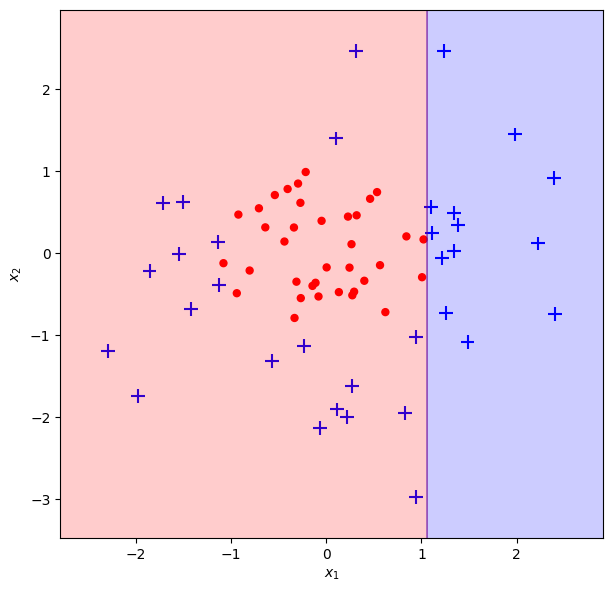

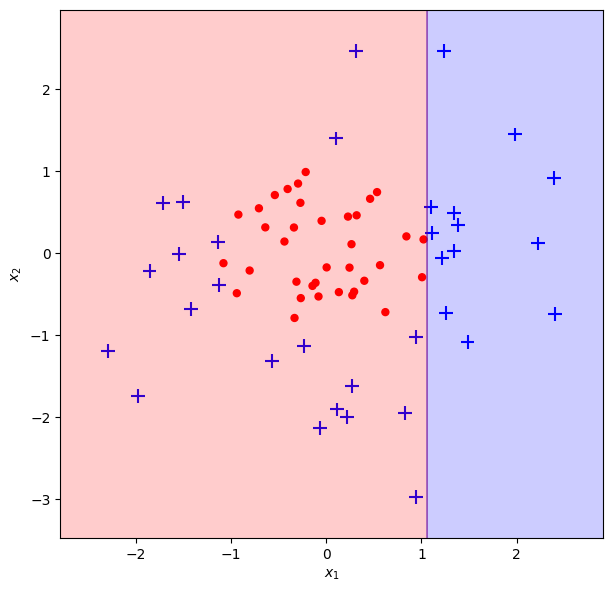

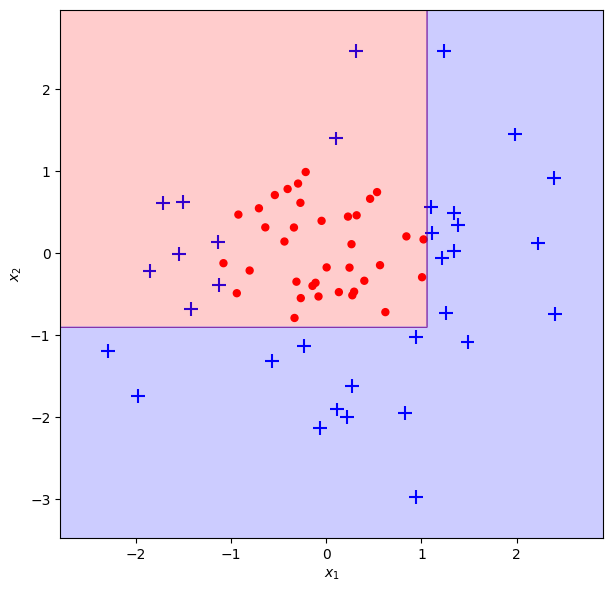

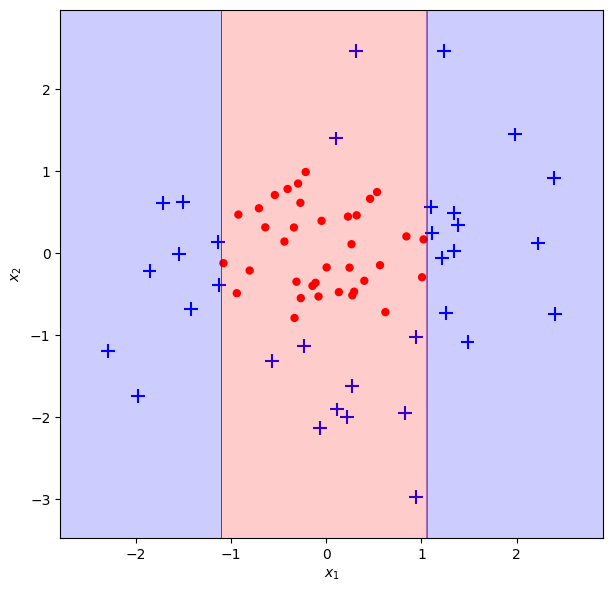

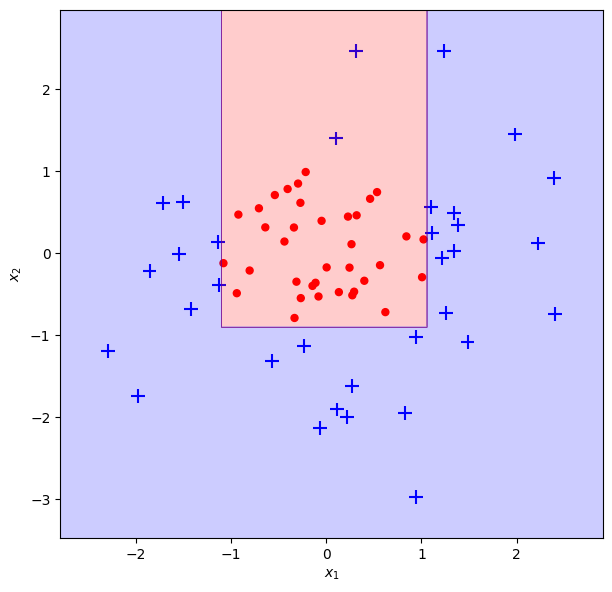

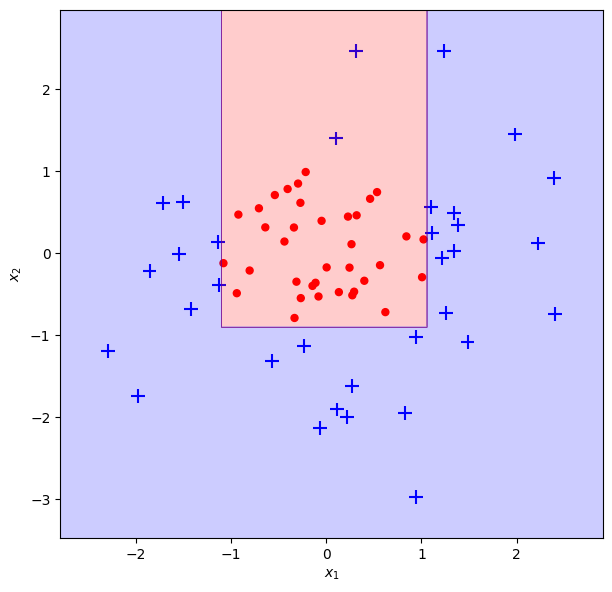

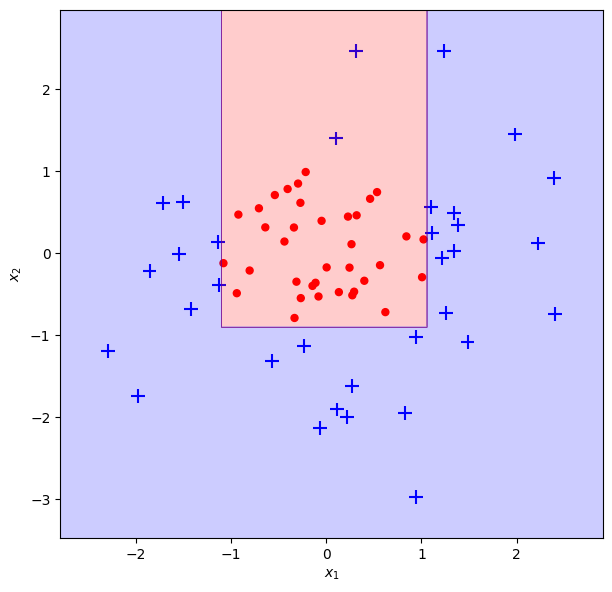

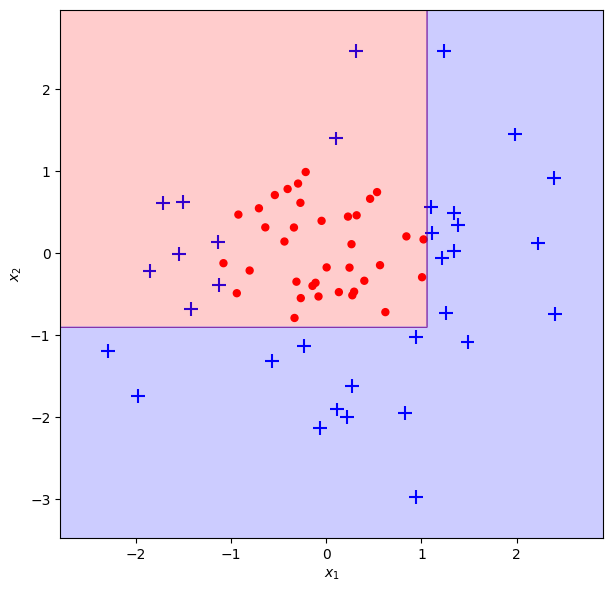

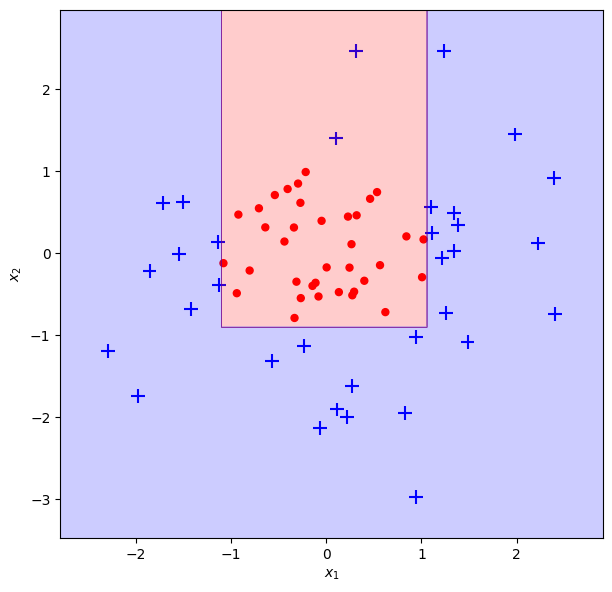

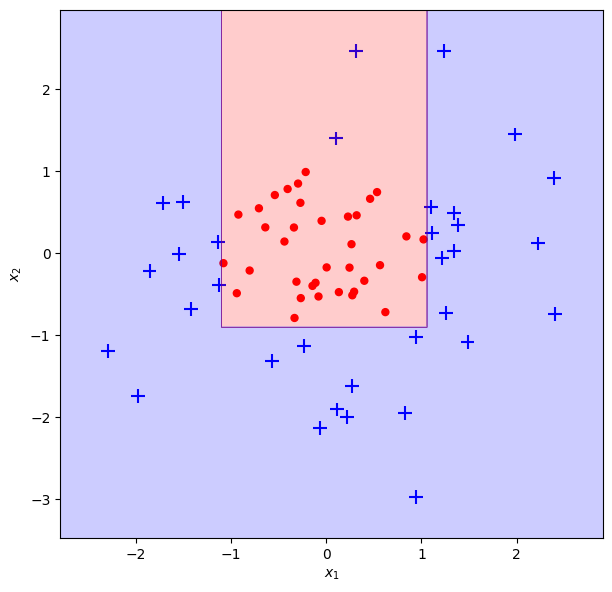

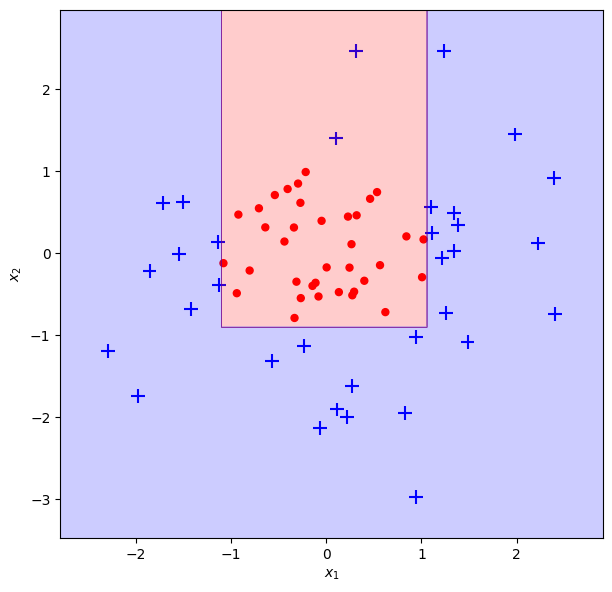

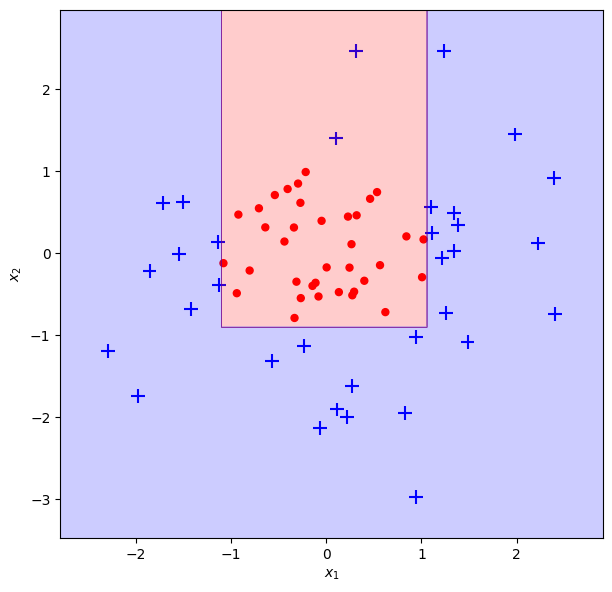

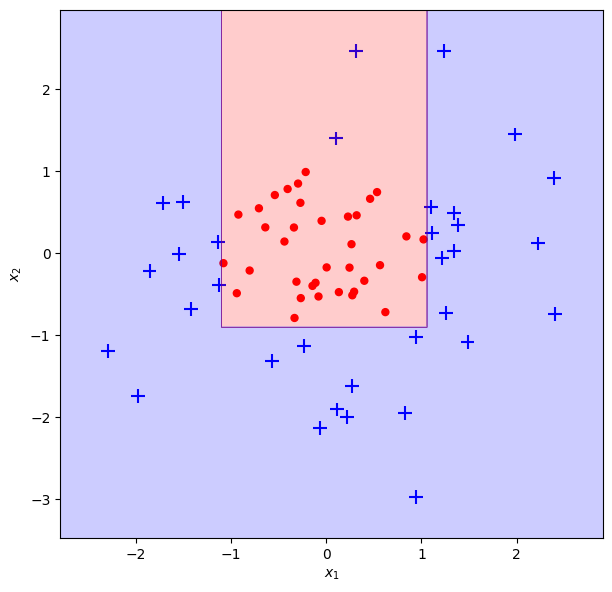

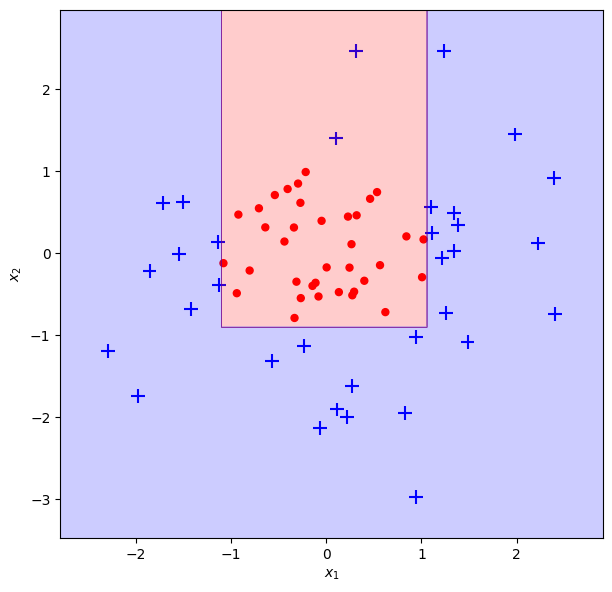

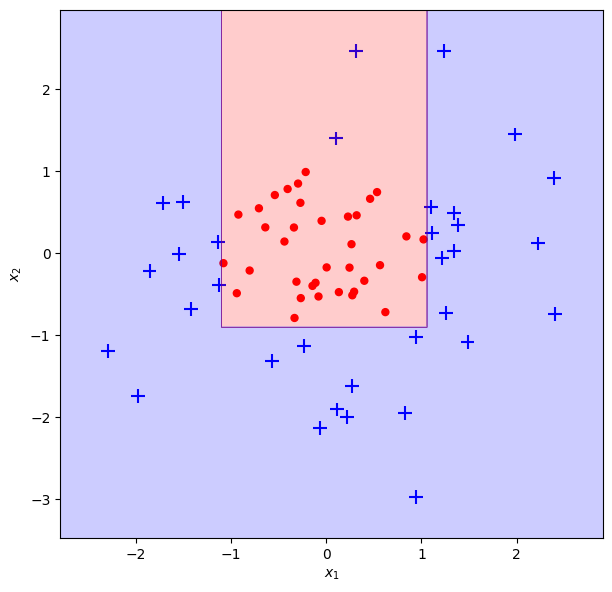

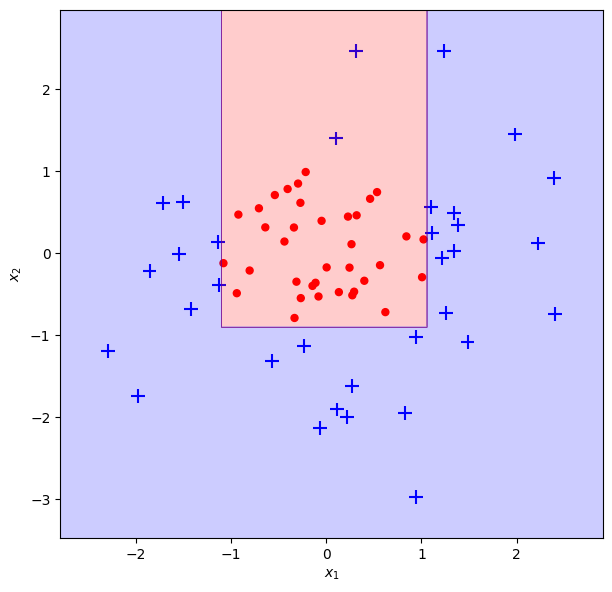

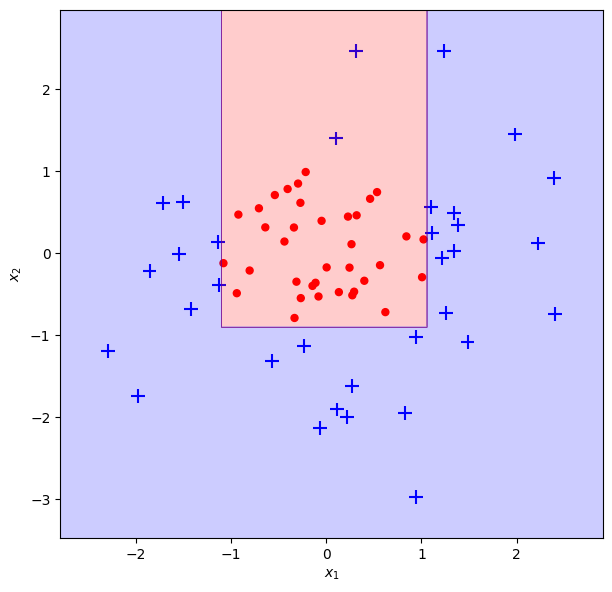

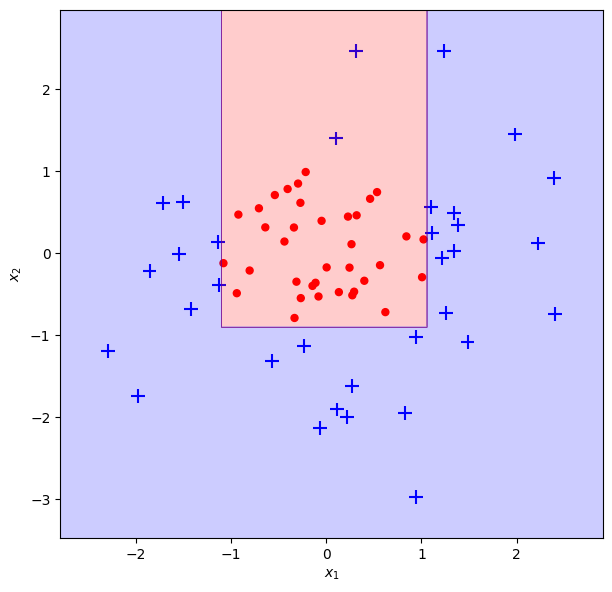

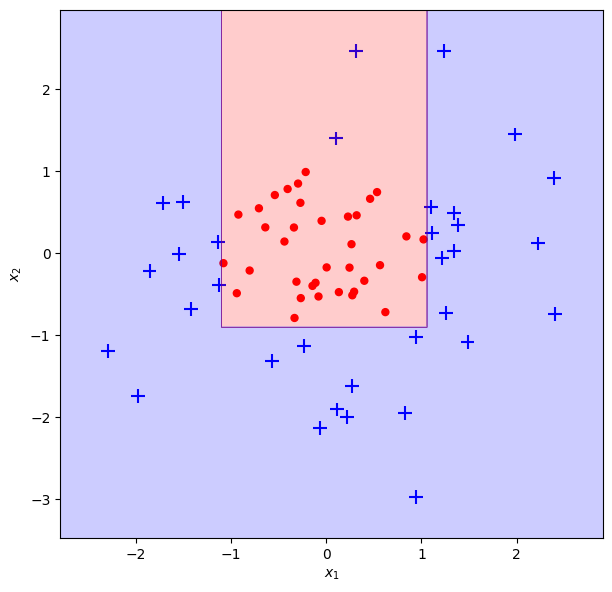

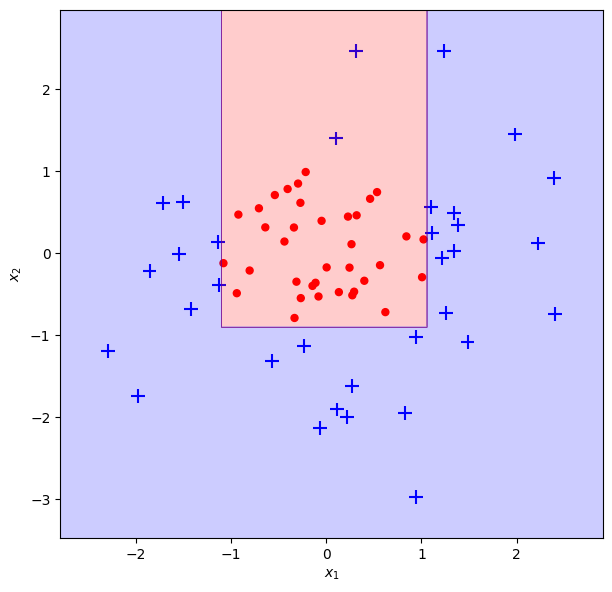

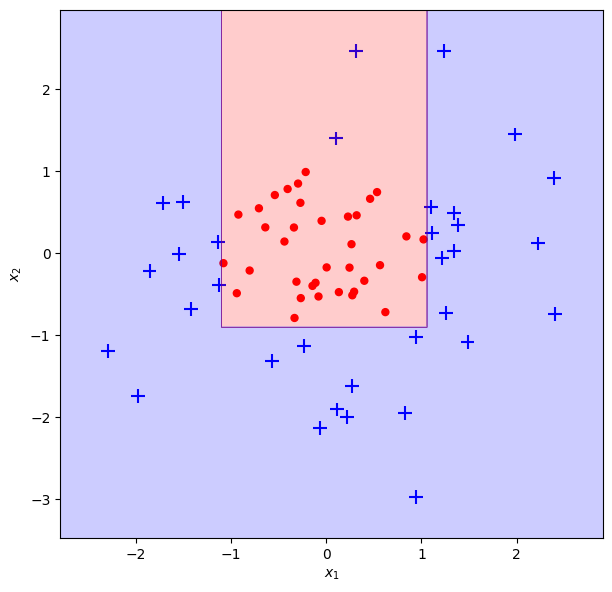

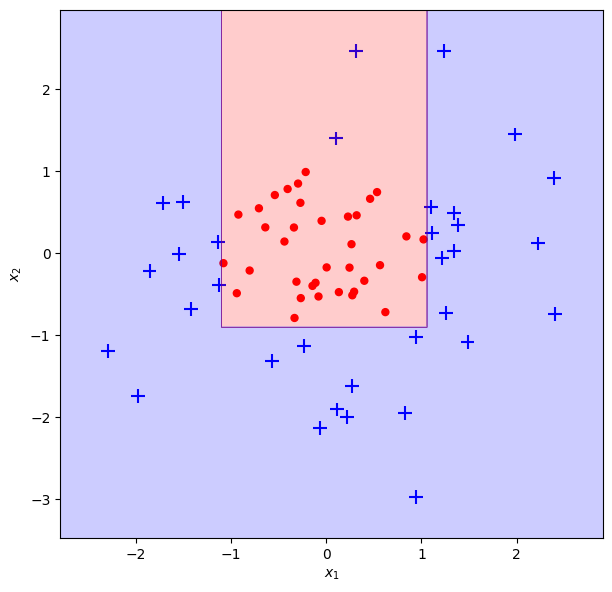

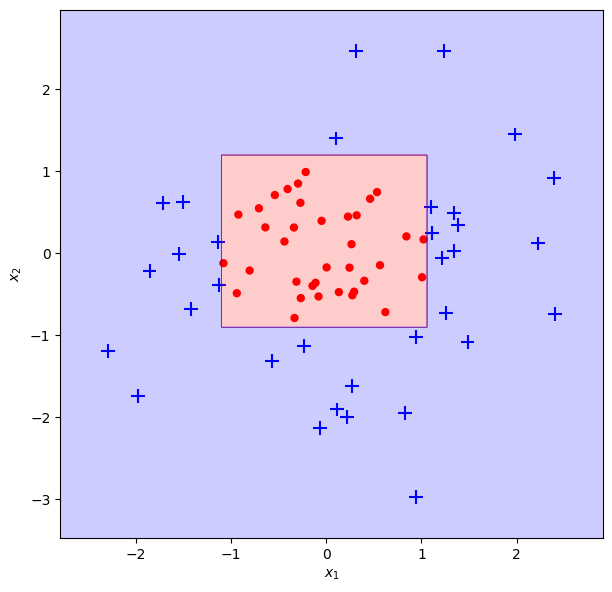

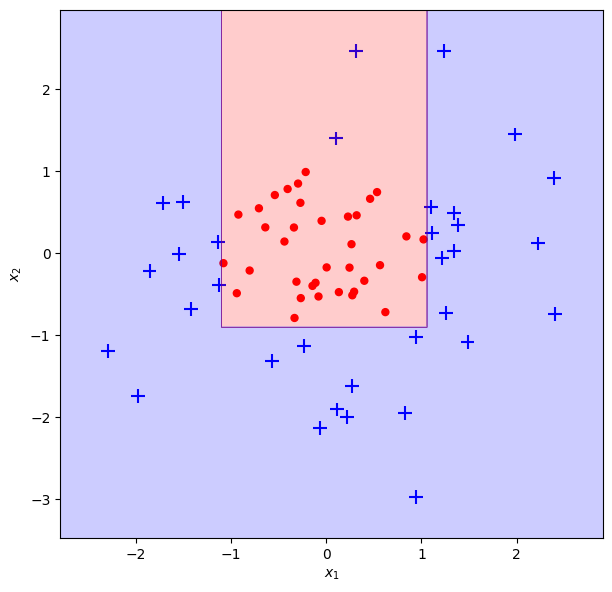

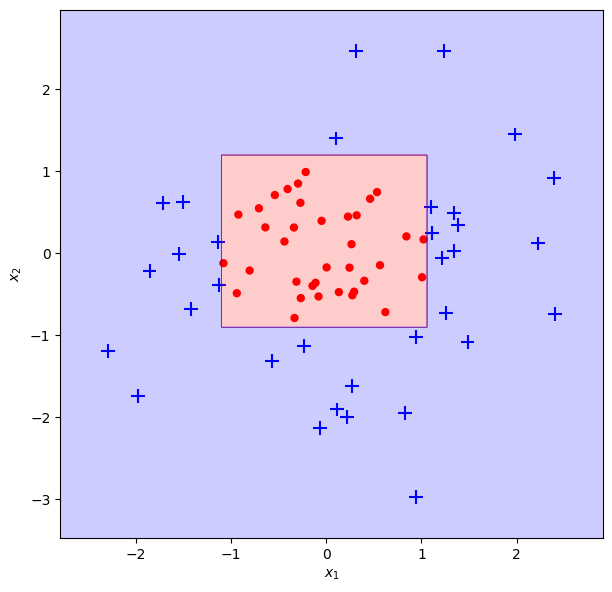

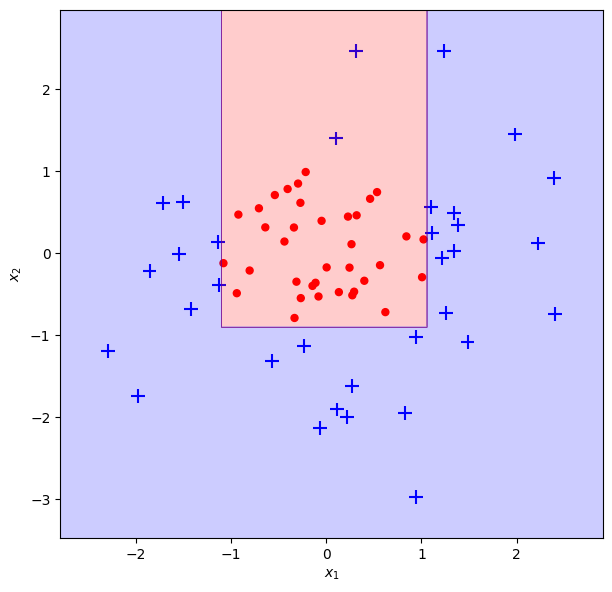

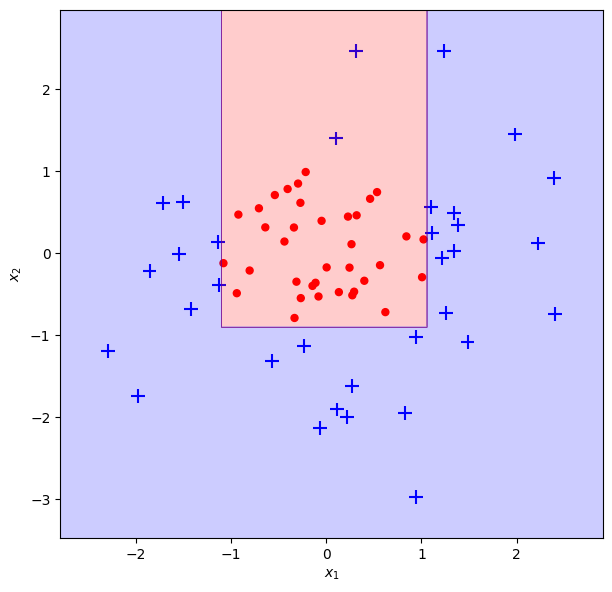

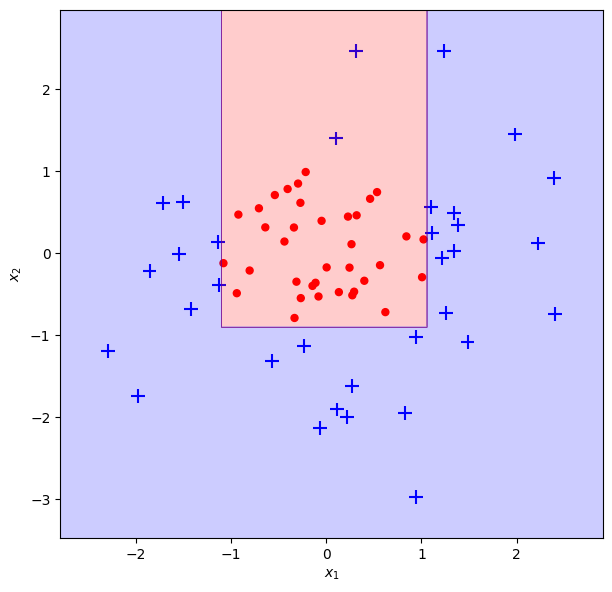

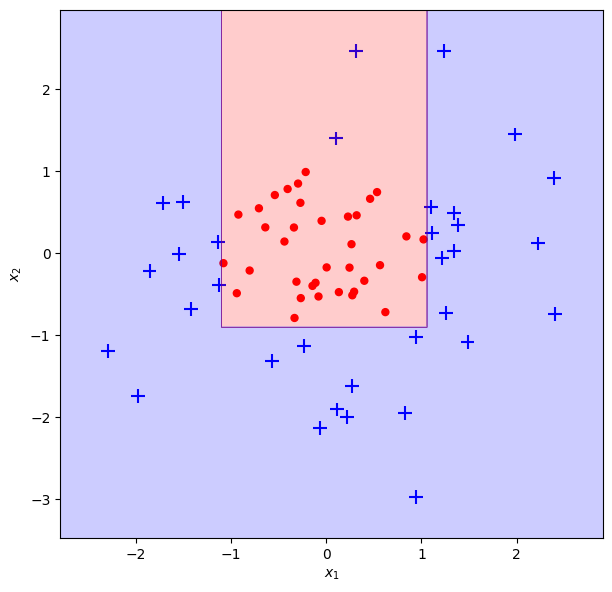

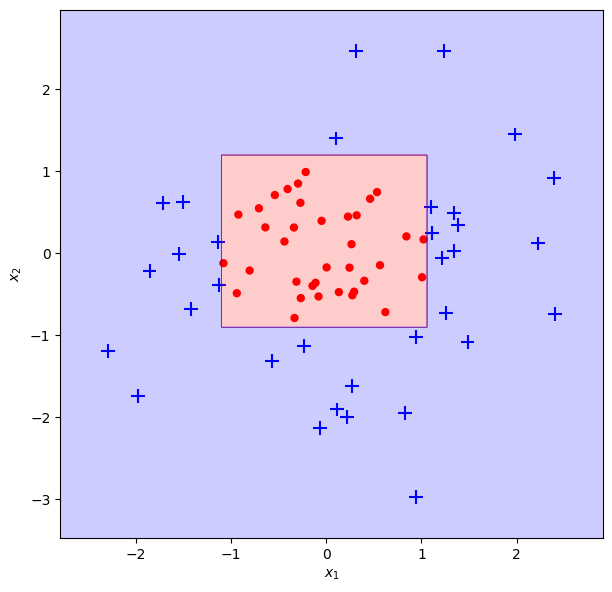

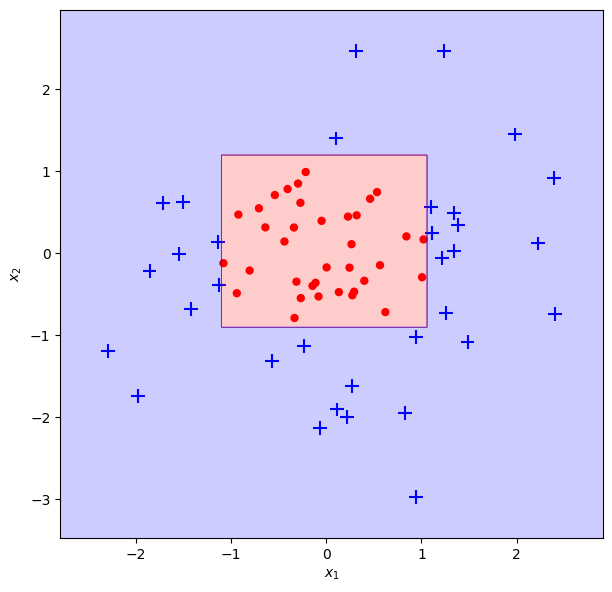

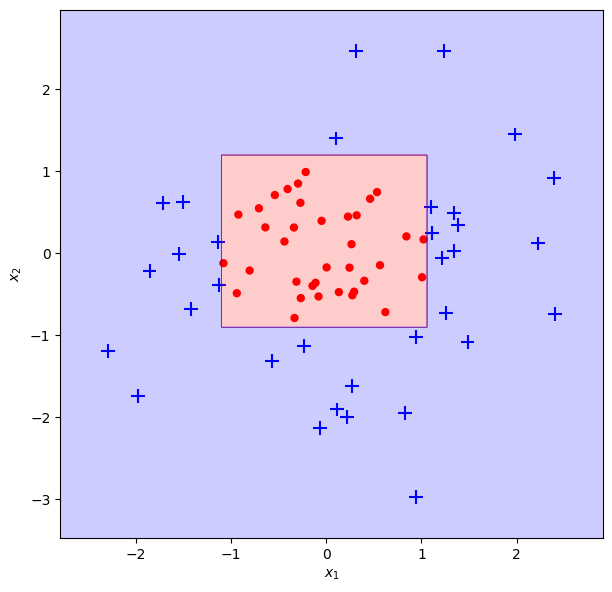

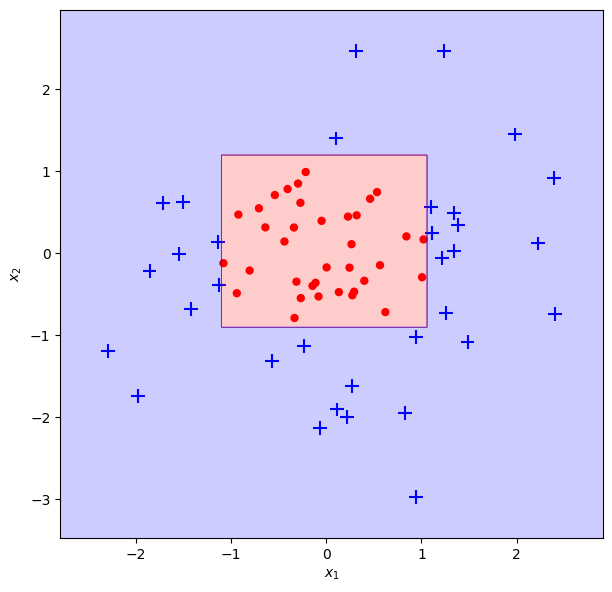

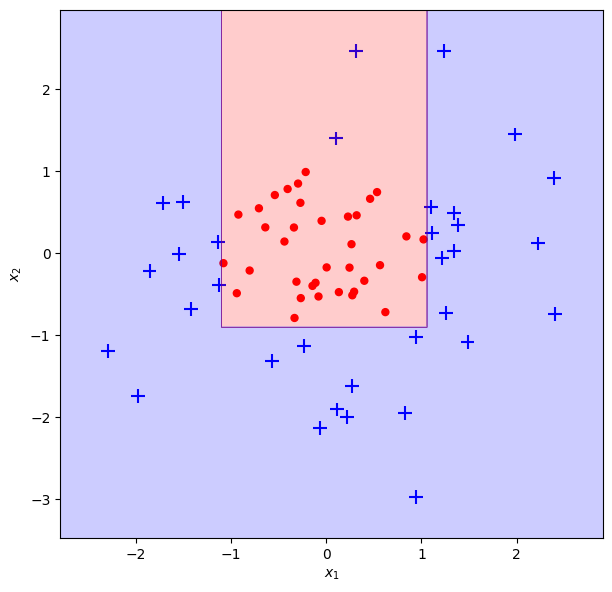

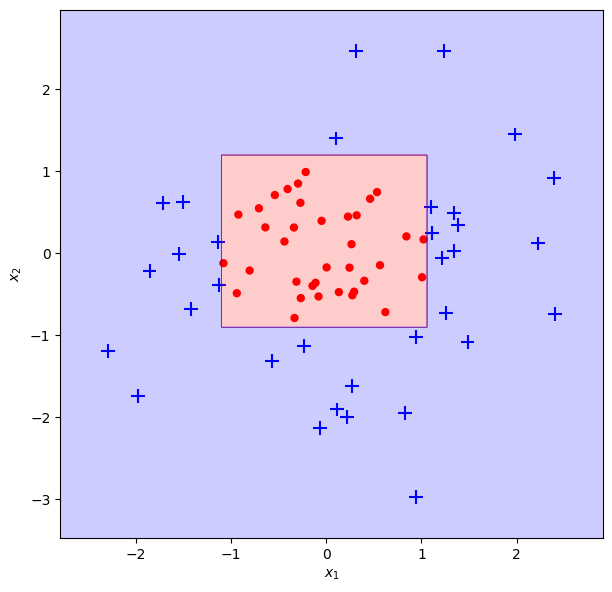

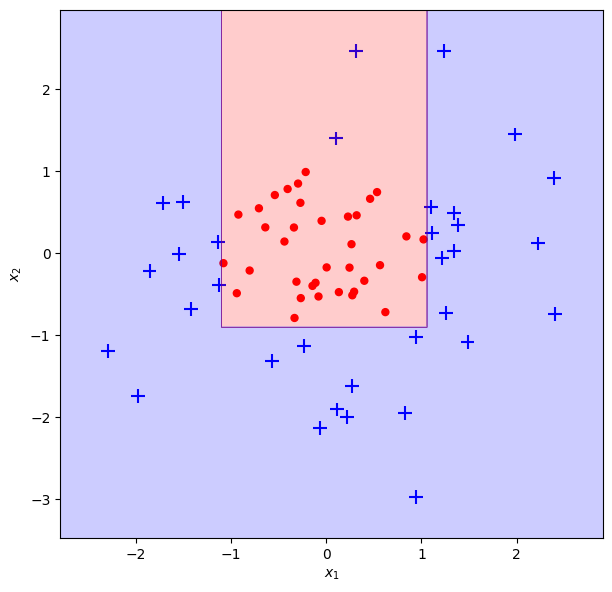

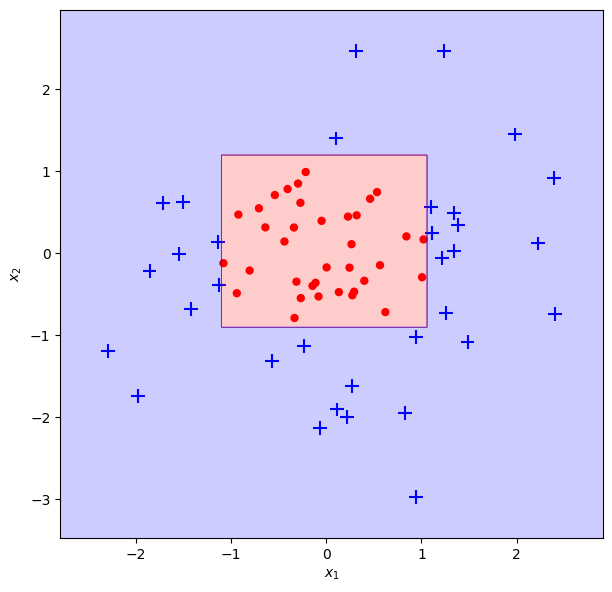

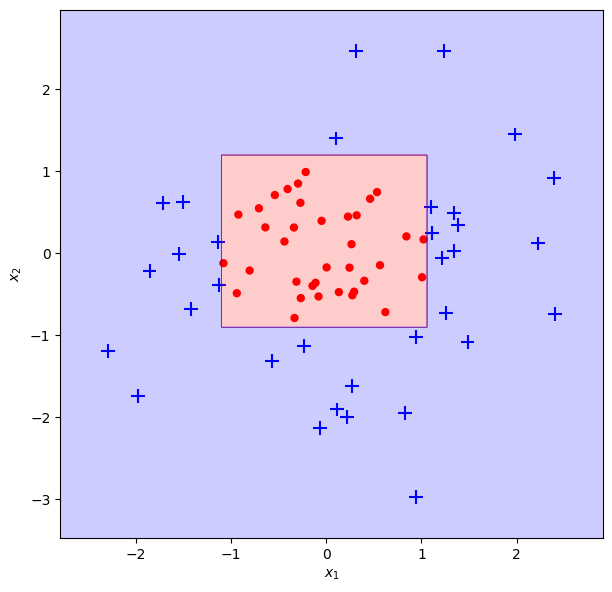

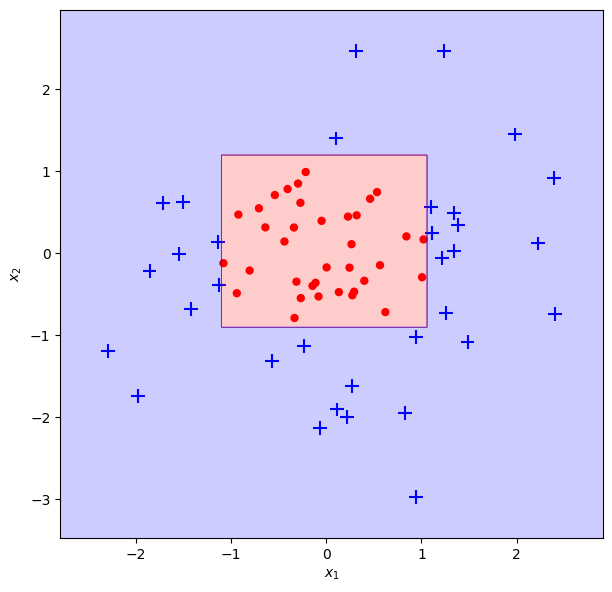

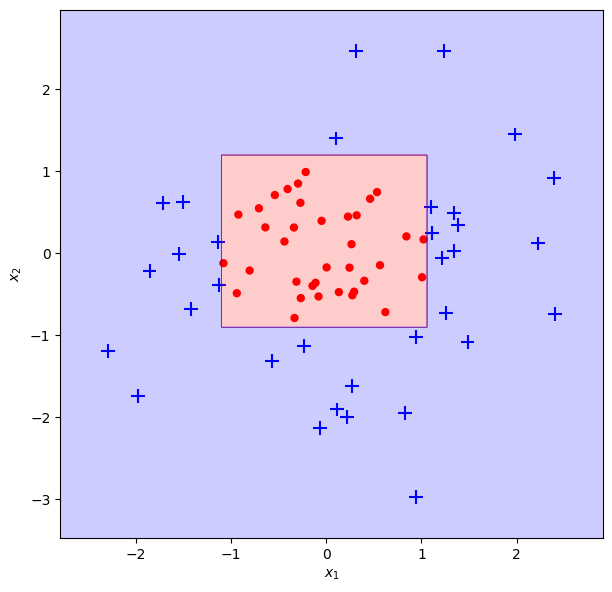

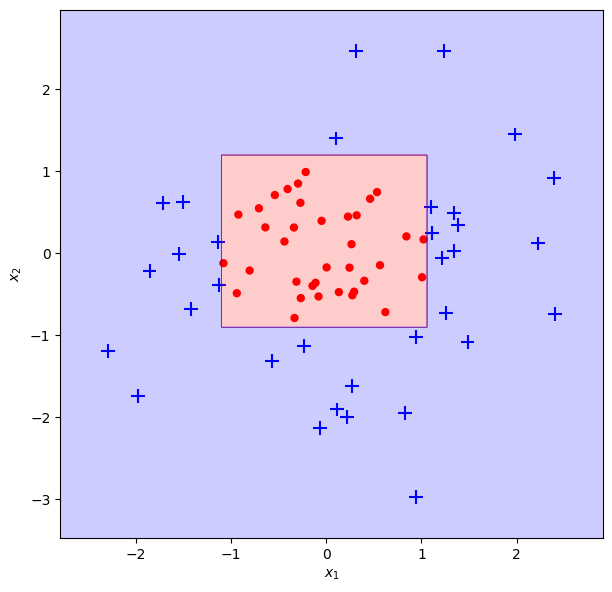

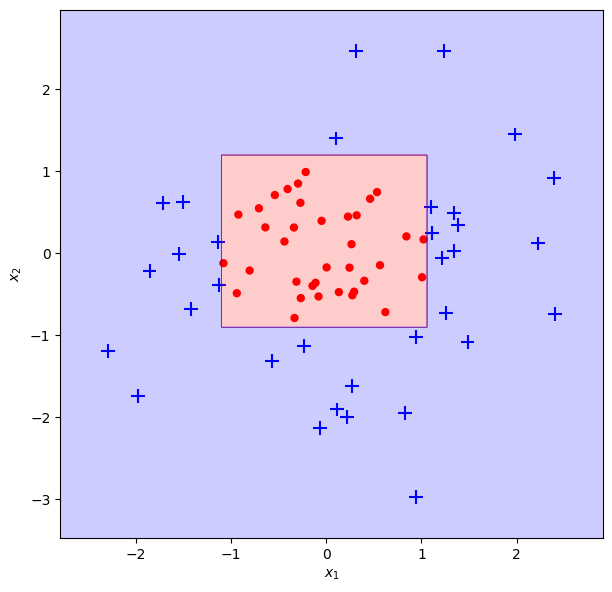

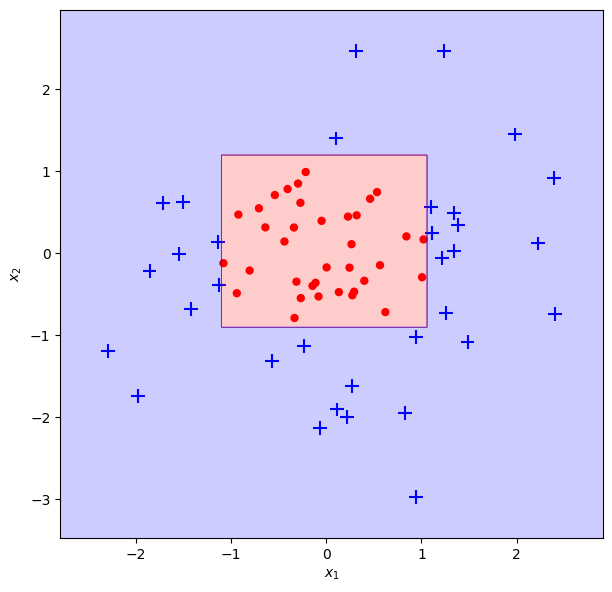

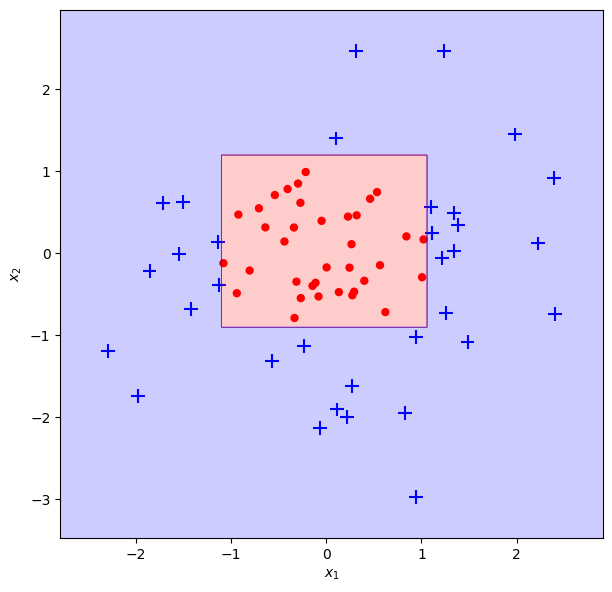

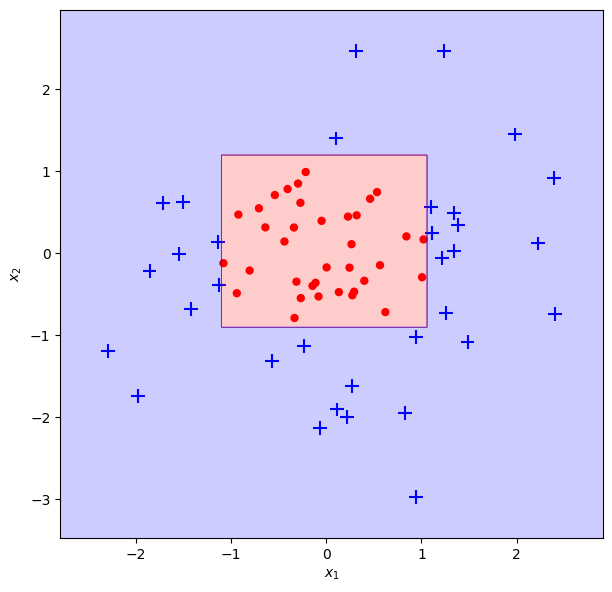

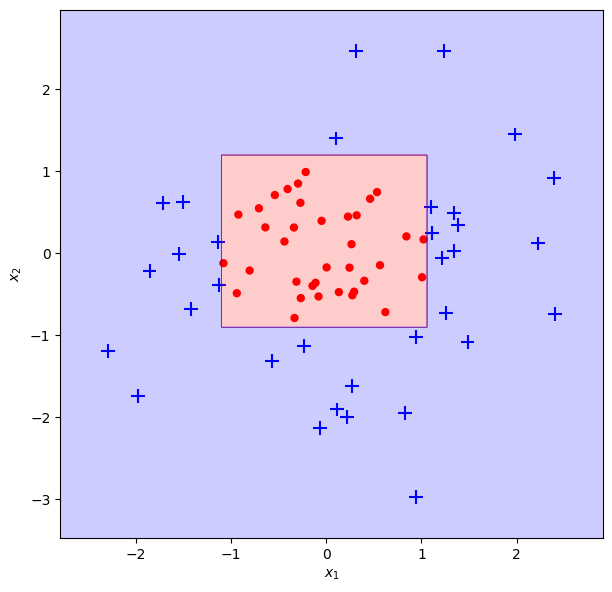

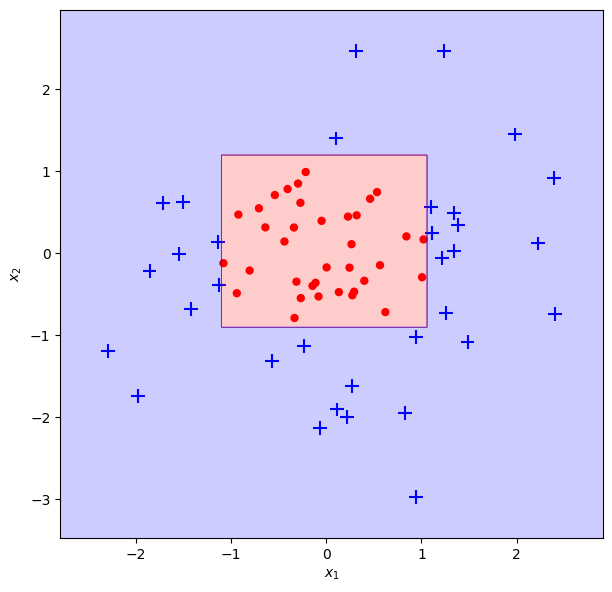

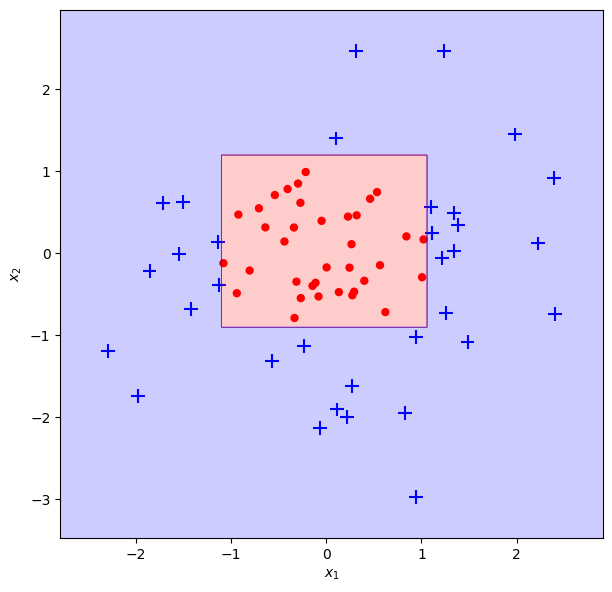

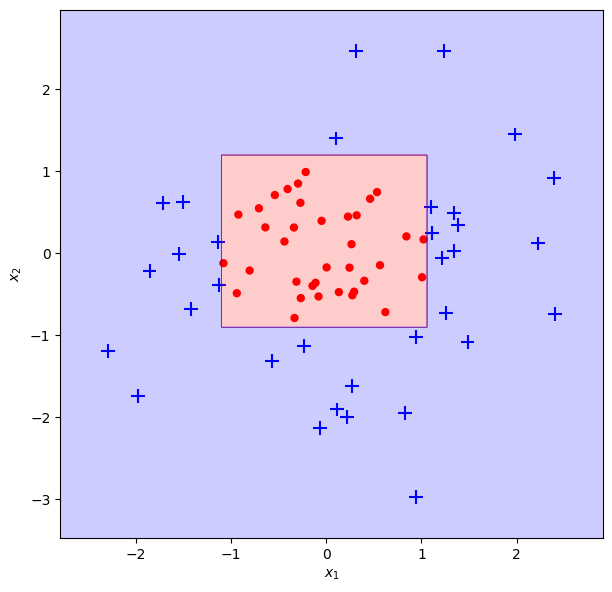

In [82]:
s1 = []
i=1
previous_train_err = 100.0
while i<n/2:
  clf = AdaBoost_classifier().fit_model(X_train, y_train, iterations=i,iteration_information=False)
  if n < 100 :
    plot_adaboost_in2D(X_train, y_train, clf)
  train_err = (clf.predict(X_train) != y_train).mean() * 100
  print('Train error for iteration ',i,' is :',train_err)
  #plot_adaboost_in2D(X_test, y_test, clf)
  #test_err = (clf.predict(X_test) != y_test).mean() * 100
  #print('Test error:',test_err)
  s1.append(train_err)
  i = i + 1
print("For train set")
print("Minimum error is ",min(s1))
print("Number of ierations to reach minimum error is ",s1.index(min(s1))+1) 
min_test = s1.index(min(s1))+1

For number of data points  99
Minimum number of iterations for minimum training error is  23
Minimum number of iterations for minimum testing error is  23
The minimum number of iterations selected for n =  99  is  23
Plotting the Adaboost classifier for above minimum iterations
Train error: 0.0
Test error: 13.333333333333334


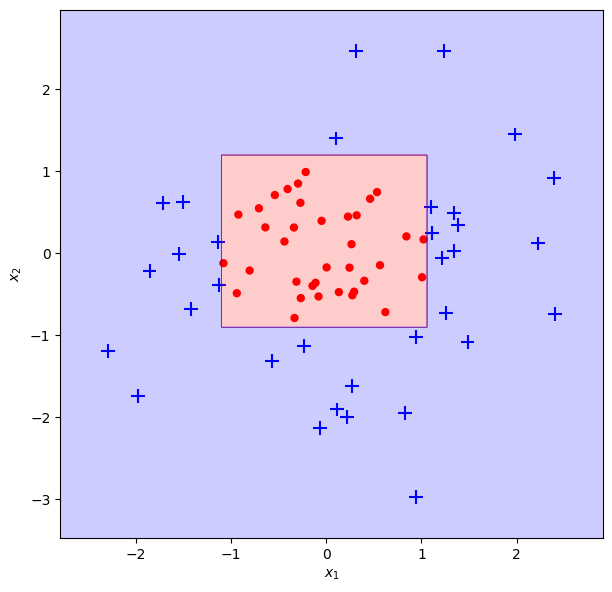

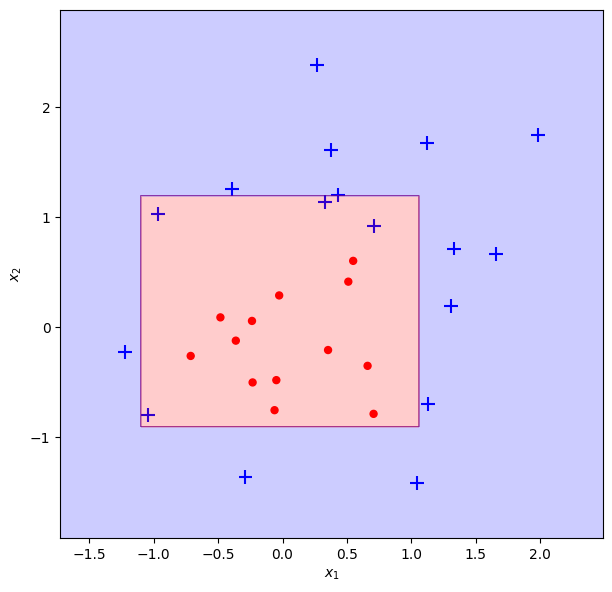

In [83]:
print("For number of data points ",n)
print("Minimum number of iterations for minimum training error is ",min_train)
print("Minimum number of iterations for minimum testing error is ",min_test)
print("The minimum number of iterations selected for n = ",n," is ",max(min_train,min_test))
print("Plotting the Adaboost classifier for above minimum iterations")
model = AdaBoost_classifier().fit_model(X_train,y_train,iterations=max(min_train,min_test),iteration_information=False)
plot_adaboost_in2D(X_train,y_train,model)
plot_adaboost_in2D(X_test,y_test,model)
train_err = (model.predict(X_train) != y_train).mean() * 100
print('Train error:',train_err)
test_err = (model.predict(X_test) != y_test).mean() * 100
print('Test error:',test_err)

# In this way we can see the different number of weak classifiers are required for different number of Data points.